# Concevez une application au service de la santé publique

Objectifs: 
-  Traiter le jeu de données afin de repérer des variables pertinentes pour les traitements à venir. Automatiser ces traitements pour éviter de répéter ces opérations. Le programme doit fonctionner si la base de données est légèrement modifiée (ajout d’entrées, par exemple). 
- Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement. L’appel à projets spécifie que l’analyse doit être simple à comprendre pour un public néophyte. Soyez donc attentif à la lisibilité : taille des textes, choix des couleurs, netteté suffisante, et variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…) pour illustrer au mieux votre propos.
-  Confirmer ou infirmer les hypothèses  à l’aide d’une analyse multivariée. Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats.
- Élaborer une idée d’application. Identifier des arguments justifiant la faisabilité (ou non) de l’application à partir des données Open Food Facts.
- Rédiger un rapport d’exploration et pitcher votre idée durant la soutenance du projet.

# Idée d'application

Les recommandations du PNNS sont les suivantes:
- Au moins 5 fruits et légumes par jour
- Des féculents à chaque repas selon l’appétit
- 3 produits laitiers (lait, yaourt, fromage) par jour
- 1 à 2 portions de viande, œufs et produits de la pêche par jour
- Limiter les matières grasses ajoutées, le sucre et le sel

A partir d'un aliment scanné, proposer une sélection de yaourt et/ou fruit(s) pour se rapprocher, sur le repas, des recommandations de santé en termes des apports en macronutriments:

* nutriments
    - lipides 35-40% Apports en Energie Totaux
    - protides 10-20% AET
    - glucides 40-55% AET
    - fibres: 30g (environ 2-3% AET)

On va donc avoir besoin de renseignements concernant les apports nutritionnels et notamment l'énergie, les apports en protéines, lipides, glucides et fibres ainsi que les types d'aliments. Eventuellement, on pourra y ajouter le nutriscore et l'ecoscore pour pouvoir faire une sélection des produits les plus écologiques et sains (dans leur catégorie).

# Sommaire
### [I Exploration du jeu de données et sélection des variables](#I-Exploration-du-jeu-de-données-et-sélection-des-variables)
__[ I.1 Chargement des données et sélection des variables](#I.1-Chargement-des-données-et-sélection-des-variables)__\
__[I.2 Nettoyage du jeu de données: valeurs incohérentes et/ou extrêmes](#I.2-Nettoyage-du-jeu-de-données:-valeurs-incohérentes-et/ou-extrêmes)__\
[I.2.1 Conversion des valeurs en grammes en valeurs en kcal](#I.2.1-Conversion-des-valeurs-en-grammes-en-valeurs-en-kcal)\
[I.2.2 Nettoyage des valeurs aberrantes (1): conversion en kcal des valeurs données en kJ](#I.2.2-Nettoyage-des-valeurs-aberrantes-(1):-conversion-en-kcal-des-valeurs-données-en-kJ)\
[I.2.3 Nettoyage des valeurs aberrantes (2): sélection des individus non aberrants par la différence entre énergie calculée et énergie renseignée](#I.2.3-Nettoyage-des-valeurs-aberrantes-(2):-sélection-des-individus-non-aberrants-par-la-différence-entre-énergie-calculée-et-énergie-renseignée)\
__[I.3 Traitement des valeurs manquantes](#I.3-Traitement-des-valeurs-manquantes)__\
[](#)
[I.3.2 Nettoyage des valeurs aberrantes (bis)](#I.3.2-Nettoyage-des-valeurs-aberrantes-(bis))

### [II Analyse exploratoire](#II-Analyse-exploratoire)
__[II.1 Répartitions typiques de l'énergie et des macronutriments](#II.1-Répartitions-typiques-de-l'énergie-et-des-macronutriments)__\
[II.1.1 Répartition générale](#II.1.1-Répartition-générale)\
[II.1.2 Les catégories One-dish meals, Fruits et Milk and yogurt](#II.1.2-Les-catégories-One-dish-meals,-Fruits-et-Milk-and-yogurt)\
[II.1.3 Représentation des proportions de chaque macronutriment dans le bilan global](#II.1.3-Représentation-des-proportions-de-chaque-macronutriment-dans-le-bilan-global)\
[II.1.4 Association d'un macronutriment dominant avec un groupe de produits](#II.1.4-Association-d'un-macronutriment-dominant-avec-un-groupe-de-produits)\
__[II.2 Scores](#II.2-Scores)__\
[II.2.1 Score reflétant l'équilibre entre les macronutriments: EquiScore](#II.2.1-Score-reflétant-l'équilibre-entre-les-macronutriments:-EquiScore)\
[II.2.2 Distribution des valeurs du nutriscore](#II.2.2-Distribution-des-valeurs-du-nutriscore)\
[II.2.3 Analyse croisée des scores](#II.2.3-Analyse-croisée-des-scores)\
[II.2.4 EquiScore, Nutriscore et groupes d'aliments](#II.2.4-EquiScore,-Nutriscore-et-groupes-d'aliments)\
__[II.3 Analyse des corrélations](#II.3-Analyse-des-corrélations)__\
[II.3.1 Matrice des corrélations](#II.3.1-Matrice-des-corrélations)

# I Exploration du jeu de données et sélection des variables

## I.1 Chargement des données et sélection des variables

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mticker
#from mticker import AutoMinorLocator
import statsmodels.api as sm
from statsmodels.formula.api import ols
import missingno as msno

# Fonctions écrites pour ce notebook.
from cleaning import load_select, weight_to_energy, create_distrib 
from cleaning import joule_to_kcal, replace_with_nan, make_mask, assign_grade
import cleaning as cln

In [42]:
# dataset à analyser
dataset = "./en.openfoodfacts.org.products.csv"

# variables retenues pour l'analyse
selected_cols = ['product_name',
                 'categories_tags',
                 'countries_tags',
                 'pnns_groups_2',
                 'energy-kcal_100g',
                 'fat_100g',
                 'nutrition-score-fr_100g',
                 'nutriscore_grade',
                 'fiber_100g',
                 'proteins_100g',
                 'carbohydrates_100g']

# restriction aux pays pour lesquels countries_tags="en:france"
restr="en:france"

# Chargement du dataset, sélection des variable (colonnes) et restriction aux countries_tags="en:france"
df1 = load_select(dataset, selected_cols, restr)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (0,8,13,19,20,21,22,23,27,28,29,31,38,47,52,55,64,134) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Aperçu global du jeu de données, avec les variables sélectionnées.
1. Aperçu des premières lignes et colonnes

In [43]:
df1.head()

,product_name,categories_tags,pnns_groups_2,energy-kcal_100g,fat_100g,nutrition-score-fr_100g,nutriscore_grade,fiber_100g,proteins_100g,carbohydrates_100g
0,jeunes pousses,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Vitória crackers,NaN,unknown,375.0,7.0,NaN,NaN,NaN,7.8,70.1
2,Cacao,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,moutarde au moût de raisin,"en:groceries,en:condiments,en:sauces,en:mustards",Dressings and sauces,NaN,8.2,18.0,d,0.0,5.1,29.0
6,Sfiudwx,fr:xsf,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Restriction aux "One dish meal", "Fruits" et "Yoghourts"
selected_groups = ['One-dish meals','Fruits', 'Milk and yogurt', 'fruits']
df1 = df1.loc[df1.pnns_groups_2.isin(selected_groups)]
    
###### fusion des pnns_groups "Fruits" et "fruits"
df1.loc[:, "pnns_groups_2"] = df1["pnns_groups_2"].apply(lambda x: "Fruits" if x=='fruits' else x)

##### Ecriture du dataframe dans un fichier csv
df1.to_csv('./df1.csv', index_label=False)

2. Matrice de remplissage

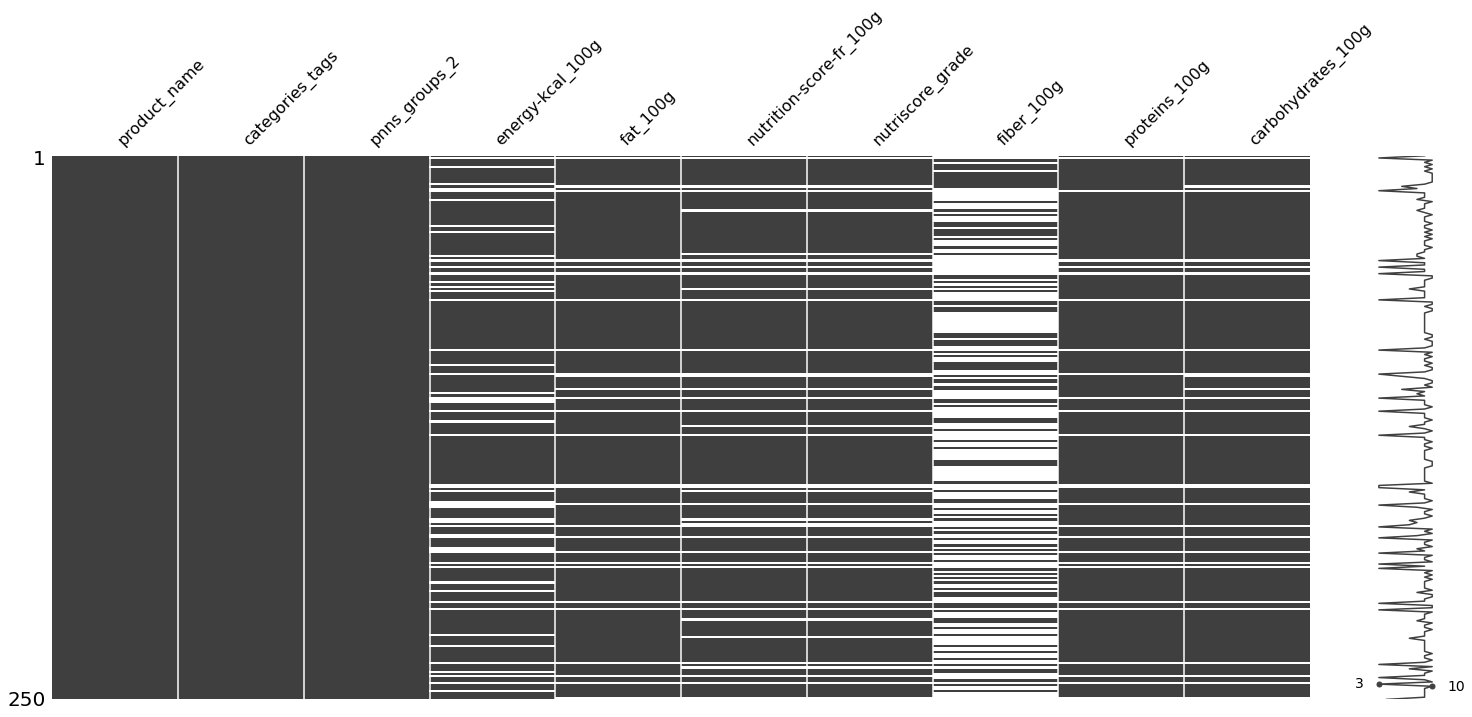

In [45]:
msno.matrix(df1.sample(250))
plt.show()

## I.2 Nettoyage du jeu de données: valeurs incohérentes et/ou extrêmes

In [175]:
df1 = pd.read_csv("./df1.csv")

Il y a clairement des valeurs atypiques et/ou aberrantes dans ce jeu de données...

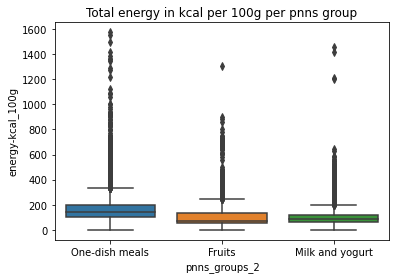

Proportion de valeurs atypiques et/ou aberrantes, hors de l'intervalle [Q1 - 1,5(Q3-Q1), Q3 + 1,5(Q3-Q1)]:
Proportion pour  One-dish meals : 0.13
Proportion pour  Fruits : 0.15
Proportion pour  Milk and yogurt : 0.13


In [176]:
## graphe
sns.boxplot(x=df1["pnns_groups_2"],
            y=df1["energy-kcal_100g"],
           )
#plt.xlabel("energy-kcal_100g")
#plt.ylabel("total_energy_from_nutriments")
plt.title("Total energy in kcal per 100g per pnns group")
plt.show()

print("Proportion de valeurs atypiques et/ou aberrantes, hors de l'intervalle [Q1 - 1,5(Q3-Q1), Q3 + 1,5(Q3-Q1)]:")
for g in df1["pnns_groups_2"].unique():
    data = df1.loc[df1.pnns_groups_2==g, "energy-kcal_100g"]
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    max_val = q1 + 1.5*(q3-q1)
    outliers = data[data > max_val]
    proportion_outliers = outliers.shape[0]/data.shape[0]
    print("Proportion pour ", g,": {:.2f}".format(proportion_outliers))

### I.2.1 Conversion des valeurs en grammes en valeurs en kcal

Comme notre application consiste en la sélection de produits permettant d'atteindre les ANC, et que ces dernières sont généralement données en % des apports énergétiques, on commence par créer de nouvelles colonnes contenant les valeurs en kcal associées aux macronutriments, et renseignées en g.

In [177]:
# Colonnes sur lesquelles opérer les conversions
start_cols = ["fat_100g", "carbohydrates_100g", "proteins_100g", "fiber_100g"]

# Colonnes à créer avec le coefficient de conversion g --> kcal associé
new_cols = [("fat_kcal", 9), ("carbohydrates_kcal", 4), ("proteins_kcal", 4), ("fiber_kcal", 1.9)]

# Conversions et créations des colonnes
for (nc, sc) in zip(new_cols, start_cols):
    df1 = weight_to_energy(df1, sc, nc[0], nc[1])

    
# Calcul de la somme des valeurs obtenues pour chaque ligne et création d'une nouvelle colonne
# "total_energy_from_nutriments"
df1.loc[:, "total_energy_from_nutriments"] = df1[["fat_kcal","carbohydrates_kcal","proteins_kcal", "fiber_kcal"]].apply(lambda x: np.sum(x), axis=1)

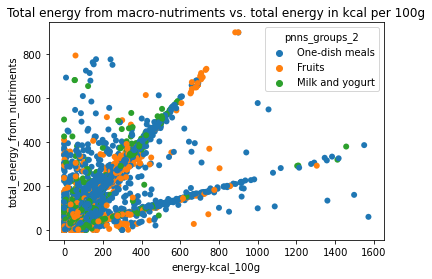

In [178]:
## graphe
sns.scatterplot(x="energy-kcal_100g", 
                y="total_energy_from_nutriments",
                data=df1,
                linewidth=0,
                hue="pnns_groups_2"
               )
plt.xlabel("energy-kcal_100g")
plt.ylabel("total_energy_from_nutriments")
plt.title("Total energy from macro-nutriments vs. total energy in kcal per 100g")
plt.show()

Etrange relation entre les deux variables... On s'attend à une relation linéaire de coefficient 1, mais deux relations semblent se dégager, la deuxième semblant à première vue correspondre à un coefficient d'environ 0,25:\
total_energy_from_nutriments = 0,25 $\times$ energy-kcal_100g.\
Peut-on corriger ces valeurs incohérentes?

### I.2.2 Nettoyage des valeurs aberrantes (1): conversion en kcal des valeurs données en kJ

Certaines valeurs renseignées dans la colonne "energy-kcal_100g" apparaissent être en fait des valeurs données en kJ. On récupère ces valeurs en sélectionnant les valeurs dans un intervalle ad hoc autour de 4,18 $\times$ total_energy_from_nutriments, et en leur appliquant le facteur de conversion $0,239=\frac{1}{4,18}$.

In [179]:
## Calcul du ratio de l'énergie calculée à partir des valeurs de macronutriments sur l'énergie renseignée
col2="energy-kcal_100g"
col1="total_energy_from_nutriments"
ratio = create_distrib(df1, col1=col1, col2=col2, reverse_cols=False, method="ratio", mask="notna")

Affichons la distribution "ratio"

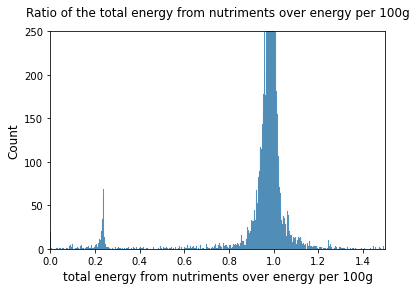

In [180]:
sns.histplot(ratio[ratio<2])
plt.xlim([0, 1.5])
plt.ylim([0, 250])
plt.title("Ratio of the total energy from nutriments over energy per 100g", pad=15)
plt.xlabel("total energy from nutriments over energy per 100g", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

In [181]:
# on ne garde dans la Series ratio que les valeurs comprises entre 0.1 et 0.4. Les valeurs intéressantes 
# se trouvent vers 0.25 et ainsi on peut calculer une moyenne et un écart-type raisonnables sur cette 
# distribution
ratio = ratio[(ratio>0.1) & (ratio<0.4)]

# Moyenne et écart-type de la "distribution" ratio
mean = ratio.mean()
sigma = ratio.std()

# cut-off associés
cut_off_high = mean + sigma
cut_off_low = mean - sigma

df1 = joule_to_kcal(df1, "energy-kcal_100g", "total_energy_from_nutriments", cut_off_high, cut_off_low)

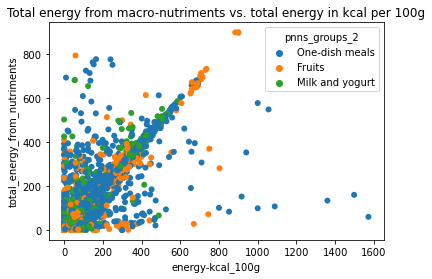

In [182]:
## graphe
sns.scatterplot(x="energy-kcal_100g", 
                y="total_energy_from_nutriments",
                data=df1,
                linewidth=0,
                hue="pnns_groups_2"
               )
plt.xlabel("energy-kcal_100g")
plt.ylabel("total_energy_from_nutriments")
plt.title("Total energy from macro-nutriments vs. total energy in kcal per 100g")
plt.show()

Le nettoyage a bien été réalisé comme on le souhaitait.

### I.2.3 Nettoyage des valeurs aberrantes (2): sélection des individus non aberrants par la différence entre énergie calculée et énergie renseignée

Certaines valeurs sont simplement aberrantes: l'énergie globale renseignée ne correspond pas du tout à l'énergie qu'on peut calculer à partir des macronutriments. En repérant ces valeurs, on peut ainsi retirer un bon nombre de valeurs incohérentes.

In [183]:
# Remplacement des valeurs nulles par des NaN pour faciliter le traitement
for col in ["total_energy_from_nutriments", "energy-kcal_100g"]:
    df1 = replace_with_nan(df1, col)

# On arrondit les valeurs de total_energy_from_nutriments.
rounded_val = df1["total_energy_from_nutriments"].apply(lambda x: np.round(x))
df1.loc[:, "total_energy_from_nutriments"] = rounded_val

# Création de la colonne complete_vars: True si toutes les colonnes target_cols sont renseignées, False sinon.
target_cols = ["total_energy_from_nutriments",
          "energy-kcal_100g",
          "fat_kcal",
          "carbohydrates_kcal",
          "proteins_kcal",
          "fiber_kcal"]
df1 = make_mask(df1, target_cols, "isna")

# On crée la distribution représentant la différence total_energy_from_nutriments - energy-kcal_100g
# Cette distribution n'est calculée que sur les lignes pour lesquelles complete_vars est True, c'est-à-dire
# les lignes pour lesquelles toutes les données sont renseignées.
diff = create_distrib(df1, mask="complete_vars")

# Ajout d'une colonne contenant la valeur de la différence entre l'énergie calculée  et l'énergie renseignée.
df1.loc[:, "diff"] = diff

Affichage de la distribution et de ses principales propriétés.

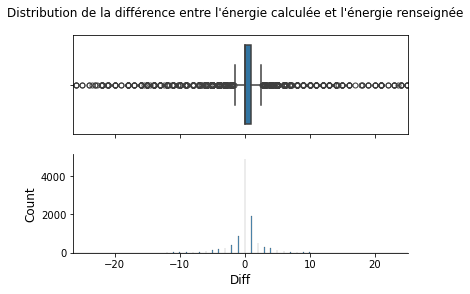

In [184]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.suptitle("Distribution de la différence entre l'énergie calculée et l'énergie renseignée")
flierprops = dict(marker="o", markerfacecolor="none")
sns.boxplot(x="diff",
            data=df1,
            flierprops=flierprops,
            ax=ax1
           )
ax1.set_xlabel("")
ax1.set_xlim([-10, 10])
sns.histplot(x="diff",
             data=df1,
             ax=ax2
            )
ax2.set_xlim([diff.mean()-diff.std(), diff.mean()+diff.std()])
ax2.set_xlabel("Diff", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
sns.despine(ax=ax2)
plt.show()

In [185]:
print("Caractéristiques de la distribution \"Diff\" (différence entre énergie calculée et énergie renseignée)")
print(df1["diff"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

Caractéristiques de la distribution "Diff" (différence entre énergie calculée et énergie renseignée)
count    11048.000000
mean        -0.628224
std         25.763468
min       -736.000000
5%          -5.000000
25%          0.000000
50%          0.000000
75%          1.000000
95%          4.000000
max        901.000000
Name: diff, dtype: float64


In [186]:
# Création d'un dataframe ne contenant que les bonnes valeurs
df1_no = df1.loc[df1.complete_vars==True].copy()
df1_no = df1_no.loc[np.abs(df1_no["diff"]-diff.mean())<2*diff.quantile(0.95)] # On ne conserve que les valeurs 
                                                                              # situées à plus de 10 unités de
                                                                              # la moyenne.
# Mise à jour du dataframe
Y = df1.loc[df1.complete_vars==True].copy()
drop_index = Y.loc[np.abs(Y["diff"]-diff.mean())>2*diff.quantile(0.95)].index
df1.drop(index=drop_index, inplace=True)

# on retire les colonnes complete_vars et diff qui ne sont plus utiles
drop_cols = ["complete_vars", "diff"]
df1.drop(columns=drop_cols, inplace=True)
df1_no.drop(columns=drop_cols, inplace=True)

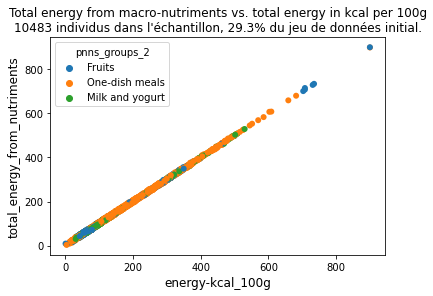

In [187]:
## graphe
sns.scatterplot(x="energy-kcal_100g", 
                y="total_energy_from_nutriments",
                data=df1_no,
                linewidth=0,
                hue="pnns_groups_2"
               )
plt.xlabel("energy-kcal_100g", fontsize=12)
plt.ylabel("total_energy_from_nutriments", fontsize=12)
plt.title('''Total energy from macro-nutriments vs. total energy in kcal per 100g
{} individus dans l'échantillon, {:.1f}% du jeu de données initial.'''.format(df1_no.shape[0],
                                                                          100*df1_no.shape[0]/df1.shape[0]))
plt.show()

Affichons les distributions associées aux variables "energy-kcal_100g", "fat_kcal", "carbohydrates_kcal" et "proteins_kcal" pour chaque pnns_group retenu, sur les données "propres" - i.e. sans valeurs incohérentes.

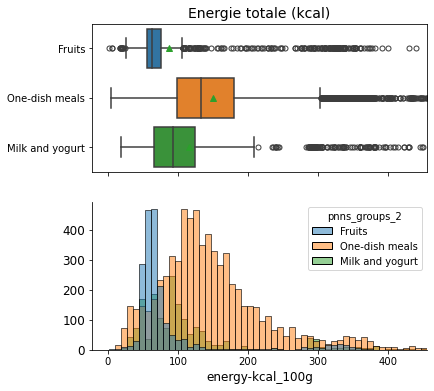

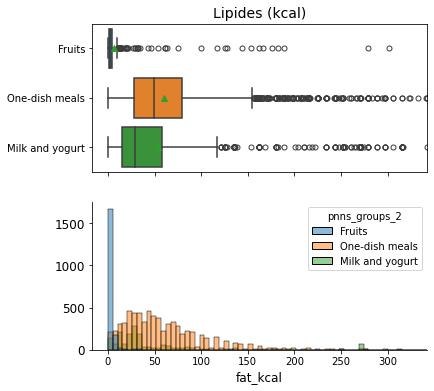

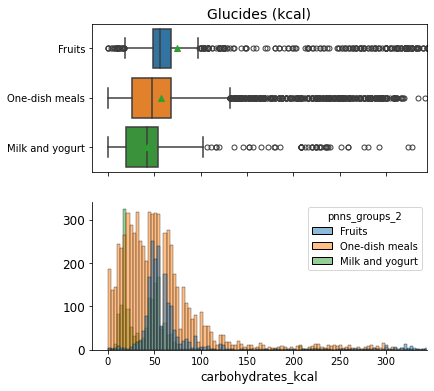

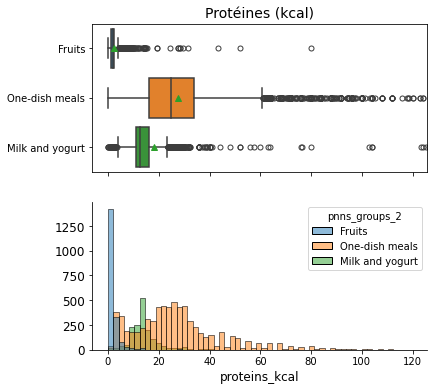

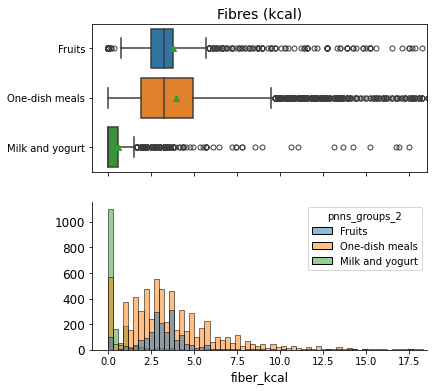

In [360]:
nutricols = ["energy-kcal_100g", "fat_kcal", "carbohydrates_kcal", "proteins_kcal", "fiber_kcal"]
titles = {"energy-kcal_100g": "Energie totale (kcal)",
          "fat_kcal": "Lipides (kcal)",
          "carbohydrates_kcal": "Glucides (kcal)",
          "proteins_kcal": "Protéines (kcal)",
          "fiber_kcal": "Fibres (kcal)"
         }
flierprops = dict(marker="o", markerfacecolor="none")
for c in nutricols:
    q = df1.groupby("pnns_groups_2")[c].quantile(0.99).max()
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
    sns.boxplot(x=c,
                y="pnns_groups_2",
                data=df1_no,
                showfliers=True,
                showmeans=True,
                flierprops=flierprops,
                #palette="viridis",
                ax=ax1)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    # change the fontsize
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_xlim([-q/20, q])
    ax1.set_title(titles[c], fontsize=14)
    
    sns.histplot(x=c,
                 data=df1_no,
                 hue="pnns_groups_2",
                 ax=ax2
            )
    ax2.set_xlim([-q/20, q])
    ax2.set_xlabel(ax2.get_xlabel(), fontsize=12)
    ax2.tick_params(axis="y", labelsize=12)
    ax2.set_ylabel("")
    #ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=10)
    sns.despine(ax=ax2)
    plt.tight_layout
    plt.show()

## I.3 Traitement des valeurs manquantes

On peut essayer d'imputer les valeurs manquantes en remplaçant par les moyennes pour une même catégorie. La colonne "categories_tags" va nous servir à cela. Chaque valeur de categorie_tags est en fait une suite de tags. La structure de cette variable est telle que le premier tag est le plus général, et le dernier le plus particulier. En utilisant le dernier tag, on augmente donc nos chances d'imputer avec une valeur la moins "incorrecte" possible.

In [471]:
# Imputation par les moyennes associées aux groupes combinés {pnns_groups_2, first_tag}, où "first_tag" 
# correspond au premier tag de la variable categories_tags
def imputation(df_no, df, pos=1):
    
    tag = [("first_tag", 0), ("last_tag",-1)]

    Y = df_no.copy()
    X = df.copy()

    # création de la colonne identifiant le tag retenu
    Y.loc[:, tag[pos][0]] = Y.apply(lambda x: x["categories_tags"].split(",")[tag[pos][1]], axis=1)
    X.loc[:, tag[pos][0]] = X.apply(lambda x: x["categories_tags"].split(",")[tag[pos][1]], axis=1)

    # calcul des moyennes de groupe sur le dataframe des valeurs cohérentes (df1_no), d'où on a écarté 
    # les outliers (variable retenue pour la sélection des outliers: energy-kcal_100g)
    
    q1 = Y["energy-kcal_100g"].quantile(0.25)
    q3 = Y["energy-kcal_100g"].quantile(0.75)
    out_low = min(0, q1-1.5*(q3-q1))
    out_high = q3 + 1.5*(q3-q1)
    outliers = Y.loc[(Y["energy-kcal_100g"]<out_low) & (Y["energy-kcal_100g"]>out_high)].index
    Y.drop(index=outliers, inplace=True)
    data_no = Y.groupby(["pnns_groups_2", tag[pos][0]]).mean()

    # reindexation du dataframe
    X.index = pd.Index(range(0, len(X)))
    index = X.index

    # Récupération des valeurs de pnns_groups_2 et "tag"
    group_tags = X[["pnns_groups_2", tag[pos][0]]]

    # imputation des valeurs manquantes grâce aux moyennes calculées sur le dataframe des valeurs cohérentes,
    # laisse la valeur à NaN sinon.
    X = X.apply(lambda x: x.fillna(value=data_no.loc(axis=0)[x["pnns_groups_2"], x[tag[pos][0]]]) 
                if (x["pnns_groups_2"], x[tag[pos][0]]) in data_no.index 
                else np.nan, axis=1)
    return X

df_last = imputation(df1_no, df1, 1)
df_first = imputation(df1_no, df1, 0)

Comparons pour commencer les distributions obtenues sur quelques indicateurs statistiques: moyenne, médiane, écart-type.

In [472]:
for c in nutricols:
    data_g = df1[c]
    data_no = df1_no[c]
    print("statistiques pour {}".format(c))
    print("Moyennes:")
    print("df1: {:.2f}, df1_no: {:.2f}, dataset avec imputations (first_tag, last_tag): {:.2f}, {:.2f}".format(data_g.mean(), data_no.mean(), df_first[c].mean(), df_last[c].mean()))
    print("Medianes:")
    print("df1: {:.2f}, df1_no: {:.2f}, dataset avec imputations (first_tag, last_tag): {:.2f}, {:.2f}".format(data_g.median(), data_no.median(), df_first[c].median(), df_last[c].median()))
    print("Ecart-type:")
    print("df1: {:.2f}, df1_no: {:.2f}, dataset avec imputations (first_tag, last_tag): {:.2f}, {:.2f}".format(data_g.std(), data_no.std(), df_first[c].std(), df_last[c].std()))
    print("-"*40)
    print("-"*40)

statistiques pour energy-kcal_100g
Moyennes:
df1: 139.04, df1_no: 132.45, dataset avec imputations (first_tag, last_tag): 135.20, 135.62
Medianes:
df1: 113.00, df1_no: 112.00, dataset avec imputations (first_tag, last_tag): 113.94, 110.89
Ecart-type:
df1: 95.59, df1_no: 86.06, dataset avec imputations (first_tag, last_tag): 85.90, 91.38
----------------------------------------
----------------------------------------
statistiques pour fat_kcal
Moyennes:
df1: 55.90, df1_no: 49.45, dataset avec imputations (first_tag, last_tag): 53.03, 53.21
Medianes:
df1: 36.00, df1_no: 34.65, dataset avec imputations (first_tag, last_tag): 35.10, 33.30
Ecart-type:
df1: 66.85, df1_no: 55.70, dataset avec imputations (first_tag, last_tag): 64.15, 65.18
----------------------------------------
----------------------------------------
statistiques pour carbohydrates_kcal
Moyennes:
df1: 57.14, df1_no: 57.93, dataset avec imputations (first_tag, last_tag): 57.93, 57.95
Medianes:
df1: 45.60, df1_no: 48.00, da

Les distributions obtenues grâce aux imputations possède des moyennes, médianes et ecart-types différents mais proches de df1_no. Plutôt une bonne nouvelle. En particulier, les valeurs très semblables des différents écart-types vont permettre une analyse plus fine par ANOVA.

On compare les différentes distributions directement, en affichant les histogrammes associés

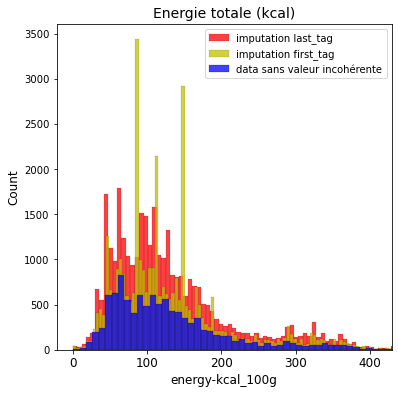

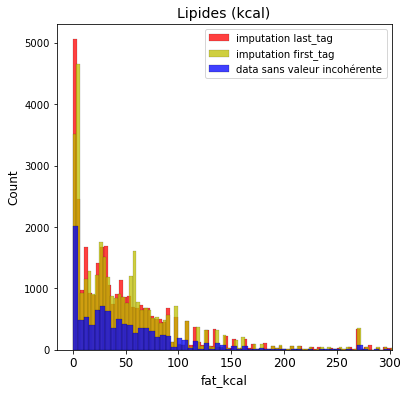

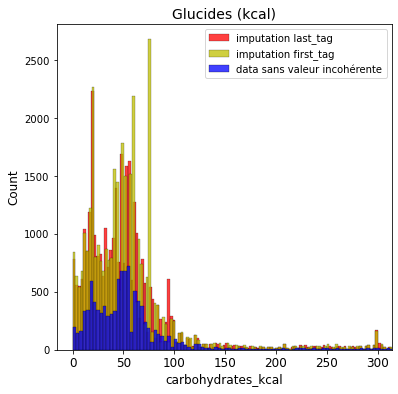

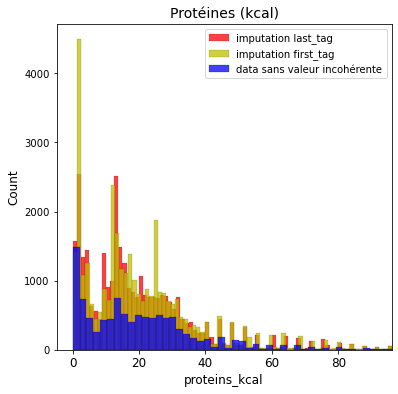

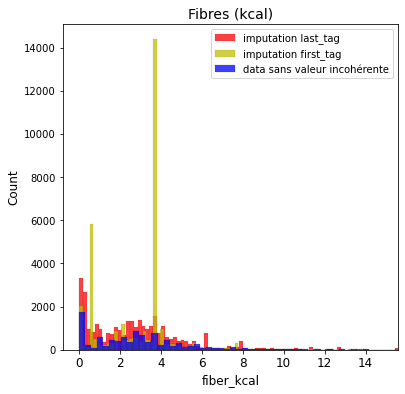

In [476]:
nutricols = ["energy-kcal_100g", "fat_kcal", "carbohydrates_kcal", "proteins_kcal", "fiber_kcal"]
titles = {"energy-kcal_100g": "Energie totale (kcal)",
          "fat_kcal": "Lipides (kcal)",
          "carbohydrates_kcal": "Glucides (kcal)",
          "proteins_kcal": "Protéines (kcal)",
          "fiber_kcal": "Fibres (kcal)"
         }
flierprops = dict(marker="o", markerfacecolor="none")
for c in nutricols:
    q = df_last[c].quantile(0.99).max()
    
    fig, ax1 = plt.subplots(figsize=(6, 6))
    sns.histplot(x=c,
                 data=df_last,
                #showfliers=True,
                #showmeans=True,
                #flierprops=flierprops,
                 color="r",
                 label='imputation last_tag',
                 ax=ax1)
    sns.histplot(x=c,
                data=df_first,
                #showfliers=True,
                #showmeans=True,
                #flierprops=flierprops,
                color="y",
                 label="imputation first_tag",
                ax=ax1)
    sns.histplot(x=c,
                data=df1_no,
                #showfliers=True,
                #showmeans=True,
                #flierprops=flierprops,
                color="b",
                 label="data sans valeur incohérente",
                ax=ax1)
    
    ax1.set_xlabel(c, fontsize=12)
    ax1.set_ylabel("Count", fontsize=12)
    # change the fontsize
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_xlim([-q/20, q])
    ax1.set_title(titles[c], fontsize=14)
    plt.legend()
    
plt.show()    

L'imputation par les last_tag semble plus performante.

**ANOVA**
1. On vérifie qu'il y a une différence significative entre les deux méthodes de remplissage en utilisant ANOVA. On utilise la bibliothèque statsmodel car elle permet de calculer eta squared qui permet de quantifier la puissance de l'effet.

In [477]:
# 1. On crée une nouvelle colonne permettant d'identifier chaque groupe. Un groupe correspond à une
# méthode d'imputation (first_tag ou last_tag)
id1 = np.full(df_last.shape[0], "last")
df_last.loc[:, "id"] = id1
id2 = np.full(df_first.shape[0], "first")
df_first.loc[:, "id"] = id2


# 2. Les nouveaux noms de variables (energy-kcal_100g changé en energy_kcal), car le model ne comprend pas
# la syntaxe "energy-kcal_100g"
df_last.rename(columns={"energy-kcal_100g":"energy_kcal"}, inplace=True)
df_first.rename(columns={"energy-kcal_100g":"energy_kcal"}, inplace=True)
indicateurs = ["energy_kcal", "fat_kcal", "carbohydrates_kcal", "proteins_kcal", "fiber_kcal"]

# 3. On crée un nouveau dataframe contenant les valeurs appartenant à chacun des groupes.
data = pd.concat([df_last, df_first])


for i in indicateurs:
    mod = ols(i+' ~ id', data=data).fit()           
    aov_table = sm.stats.anova_lm(mod, typ=2)
    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
    print("Résultats de l'analyse ANOVA pour la variable {}:".format(i))
    print("F: {:.2f}, p: {:.3f}".format(aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"]))
    print("Eta-squared: {:.4f}".format(esq_sm))
    

Résultats de l'analyse ANOVA pour la variable energy_kcal:
F: 0.39, p: 0.533
Eta-squared: 0.0000
Résultats de l'analyse ANOVA pour la variable fat_kcal:
F: 0.14, p: 0.707
Eta-squared: 0.0000
Résultats de l'analyse ANOVA pour la variable carbohydrates_kcal:
F: 0.00, p: 0.963
Eta-squared: 0.0000
Résultats de l'analyse ANOVA pour la variable proteins_kcal:
F: 0.05, p: 0.825
Eta-squared: 0.0000
Résultats de l'analyse ANOVA pour la variable fiber_kcal:
F: 8.58, p: 0.003
Eta-squared: 0.0001


D'après l'ANOVA, les distributions obtenues sont indiscernables pour tous les indicateurs, sauf fiber_kcal. Même pour cette dernière variable, l'effet (eta-squared) est très faible.

2. On vérifie de même que l'effet de l'imputation sur la distribution des valeurs est faible (idéalement inexistant)

In [478]:
# 1. Même procédure que précedemment. Y représente le dataframe des valeurs cohérentes.
idf = np.full(df1_no.shape[0], "idf")
df1_no.loc[:, "id"] = idf
Y = df1_no.copy()
Y.rename(columns={"energy-kcal_100g":"energy_kcal"}, inplace=True)

# On ne sélectionne (aléatoirement) qu'un sous-echantillon de valeurs issues de X pour que les deux échantillons
# comparés soient de même taille.
data = pd.concat([df_last.sample(len(Y)), Y])

for i in indicateurs:
    mod = ols(i+' ~ id', data=data).fit()           
    aov_table = sm.stats.anova_lm(mod, typ=2)
    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
    print("Résultats de l'analyse ANOVA pour la variable {}:".format(i))
    print("F: {:.2f}, p: {:.3f}".format(aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"]))
    print("Eta-squared: {:.4f}".format(esq_sm))

Résultats de l'analyse ANOVA pour la variable energy_kcal:
F: 5.34, p: 0.021
Eta-squared: 0.0003
Résultats de l'analyse ANOVA pour la variable fat_kcal:
F: 13.17, p: 0.000
Eta-squared: 0.0006
Résultats de l'analyse ANOVA pour la variable carbohydrates_kcal:
F: 0.53, p: 0.466
Eta-squared: 0.0000
Résultats de l'analyse ANOVA pour la variable proteins_kcal:
F: 0.01, p: 0.924
Eta-squared: 0.0000
Résultats de l'analyse ANOVA pour la variable fiber_kcal:
F: 30.70, p: 0.000
Eta-squared: 0.0015


Cette fois l'analyse nous apprend qu'il y a bien une différence significative entre le dataframe df1_no et le dataframe comportant toutes les données (imputées et originales) pour les variables energy_kcal, fat_kcal, fiber_kcal. En revanche pour carbohydrates_kcal, et proteins_kcal l'imputation ne change pas significativement la distribution des valeurs.

**Conclusion**\
Si on se fie aux indicateurs statistiques, les imputations sont satisfaisantes: même si leur effet sur la distribution statistique des données est significatif la plupart du temps, il est toujours très faible. Visuellement, on se convainc de la supériorité de l'imputation par les last_tag, qui tend moins à regrouper un grand nombre de produits dans des blocs de valeurs similaires.

<AxesSubplot:>

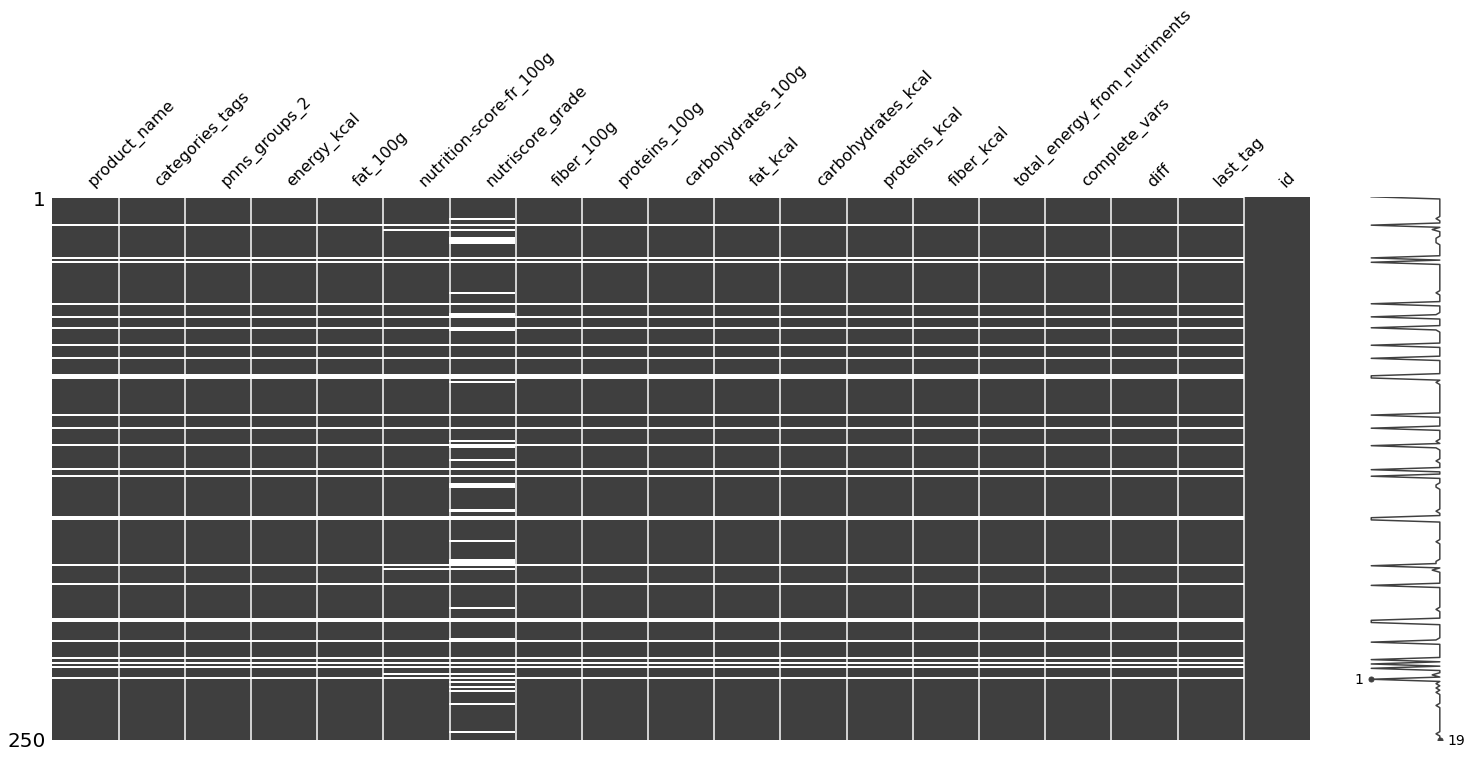

In [479]:
msno.matrix(df_last.sample(250))

In [480]:
# On retire les lignes totatelement non-renseignées
df_last.dropna(how='all', inplace=True)

# On met à jour df1 avec les données imputées
df1 = df_last

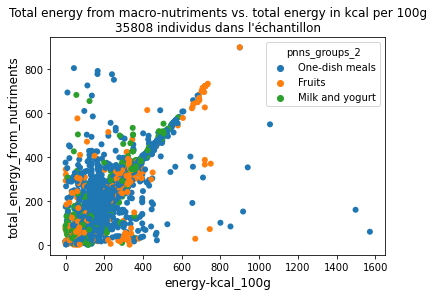

In [484]:
## graphe
sns.scatterplot(x="energy_kcal", 
                y="total_energy_from_nutriments",
                data=df1,
                linewidth=0,
                hue="pnns_groups_2"
               )
plt.xlabel("energy-kcal_100g", fontsize=12)
plt.ylabel("total_energy_from_nutriments", fontsize=12)
plt.title('''Total energy from macro-nutriments vs. total energy in kcal per 100g
{} individus dans l'échantillon'''.format(df1.shape[0]))
plt.show()

### I.3.2 Nettoyage des valeurs aberrantes (bis)

In [486]:
# On crée la distribution représentant la différence entre total_energy... et energy_...
diff = create_distrib(df1, col1="energy_kcal", method="diff")

# Mise à jour de la colonne diff
df1.loc[:, "diff"] = diff

# Récupération des index à retirer du dataframe
drop_index = df1.loc[np.abs(df1["diff"]-diff.mean())>diff.quantile(0.95)].index # utilisation du 95ème percentile 
                                                                            # plutôt que l'écart-type, trop 
                                                                            # large à cause des outliers
# On enlève les lignes correspondant aux outliers.
df1.drop(index=drop_index, inplace=True)

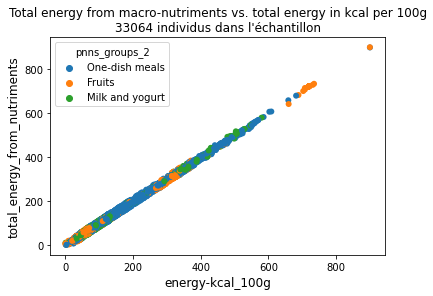

In [487]:
## graphe
sns.scatterplot(x="energy_kcal", 
                y="total_energy_from_nutriments",
                data=df1,
                linewidth=0,
                hue="pnns_groups_2"
               )
plt.xlabel("energy-kcal_100g", fontsize=12)
plt.ylabel("total_energy_from_nutriments", fontsize=12)
plt.title('''Total energy from macro-nutriments vs. total energy in kcal per 100g
{} individus dans l'échantillon'''.format(df1.shape[0]))
plt.show()

In [492]:
print("Minimum et maximum des différences observées entre énergie renseignée et énergie calculée:")
print("Minimum: {:.2f}, Maximum: {:.2f}".format(df1["diff"].min(), df1["diff"].max()))

Minimum et maximum des différences observées entre énergie renseignée et énergie calculée:
Minimum: -14.91, Maximum: 18.11


## I.4 Traitement du nutriscore_grade

Nous allons regarder les deux variables nutrition-score-fr_100g ainsi que nutriscore_grade de plus près, en gardant en tête que le nutriscore_grade est défini de la façon suivante:
- "A": score entre -15 et -2
- "B": score entre -1 et +3
- "C": score entre +4 et +11
- "D": score entre +12 et +16
- "E": score supérieur ou égal à 17

In [493]:
df1["nutriscore_grade"] = df1["nutrition-score-fr_100g"].apply(lambda x: assign_grade(x))

In [494]:
df1.to_csv("./df1_clean.csv", index_label=False)

# II Analyse exploratoire

In [2]:
df1 = pd.read_csv("./df1_clean.csv", )

## II.1 Répartitions typiques de l'énergie et des macronutriments

### II.1.1 Répartition générale

On commence par explorer les distributions associées aux différents macronutriments et à l'énergie sur le jeu de données global.

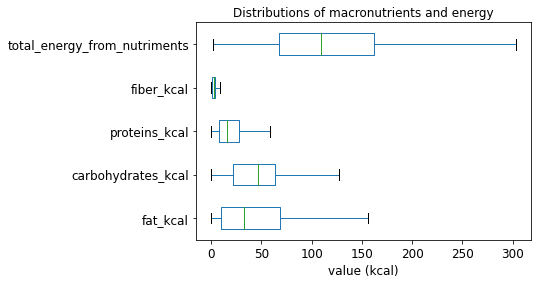

----------------------------------------
Moyennes en kcal des différentes valeurs nutritionnelles sur le dataset global:
fat_kcal                         51.495508
carbohydrates_kcal               57.271514
proteins_kcal                    20.961523
fiber_kcal                        3.056371
total_energy_from_nutriments    131.431798
dtype: float64
----------------------------------------
Médianes en kcal des différentes valeurs nutritionnelles sur le dataset global:
fat_kcal                         32.40
carbohydrates_kcal               46.80
proteins_kcal                    15.60
fiber_kcal                        2.66
total_energy_from_nutriments    109.00
dtype: float64


In [203]:
ax=df1[["fat_kcal",
   "carbohydrates_kcal",
   "proteins_kcal",
   "fiber_kcal",
   "total_energy_from_nutriments"]].plot(kind="box",
                                         vert=False, 
                                         showfliers=False,
                                         fontsize=12,
                                         xlabel="value (kcal)",
                                         title="Distributions of macronutrients and energy")
ax.set_xlabel("value (kcal)", fontsize=12)
plt.show()
print("-"*40)
print("Moyennes en kcal des différentes valeurs nutritionnelles sur le dataset global:")
print(df1[["fat_kcal",
   "carbohydrates_kcal",
   "proteins_kcal",
   "fiber_kcal",
   "total_energy_from_nutriments"]].mean())
print("-"*40)
print("Médianes en kcal des différentes valeurs nutritionnelles sur le dataset global:")
print(df1[["fat_kcal",
   "carbohydrates_kcal",
   "proteins_kcal",
   "fiber_kcal",
   "total_energy_from_nutriments"]].median())

### II.1.2 Les catégories One-dish meals, Fruits et Milk and yogurt

Combien de représentants de chaque catégorie?

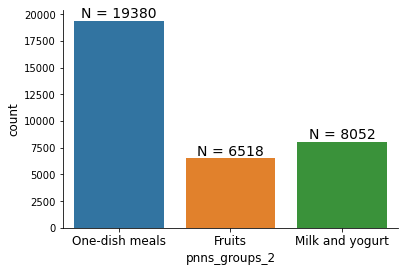

In [12]:
fig, ax = plt.subplots()
sns.countplot(x="pnns_groups_2",
              data=df1,
              ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
#ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate("N = {:.0f}".format(y), (x.mean(), y), 
            ha='center', va='bottom', fontsize=14) # set the alignment of the text
sns.despine(ax=ax)
plt.show()

Les One-dish meals sont largement surreprésentés par rapport aux deux autres catégories. Il faudra savoir en tenir compte. En attendant, regardons comment leur composition diffère.

### II.1.3 Représentation des proportions de chaque macronutriment dans le bilan global

On commence par créer un dataframe regroupant les valeurs moyennes des macronutriments pour chaque groupe d'aliment. Comme les ANC ne reposent que sur les répartitions en lipides, glucides et protéines (les fibres étant comptées à part), on ne fera reposer l'analyse qui suit que sur les répartitions de ces macronutriments.

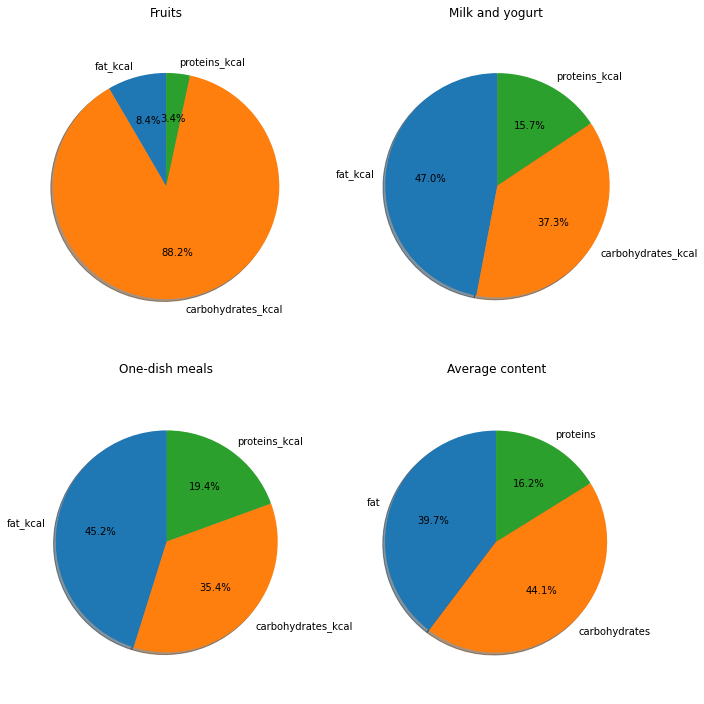

In [211]:
# On groupe les valeurs par catégorie d'aliment.
gr = df1.groupby("pnns_groups_2")[["fat_kcal", "carbohydrates_kcal", "proteins_kcal"]].mean()

# A titre de comparaison, on récupère aussi les valeurs moyennes sur l'ensemble du dataset.
gen = df1[["fat_kcal", "carbohydrates_kcal", "proteins_kcal"]].mean()

# On représente ces valeurs moyennes sous forme de proportion au bilan global pour chaque groupe d'aliment.
# Représentation sous forme de pie chart
labels = ["fat", "carbohydrates","proteins"]

# placement des titres
pad=15

# Taille de la police
fs = 12


fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax1.pie(gr.loc["Fruits"], labels = gr.columns, autopct='%1.1f%%',
shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Fruits", pad=pad, fontsize=fs)

ax2.pie(gr.loc["Milk and yogurt"], labels = gr.columns, autopct='%1.1f%%',
shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title("Milk and yogurt", pad=pad, fontsize=fs)

ax3.pie(gr.loc["One-dish meals"], labels = gr.columns, autopct='%1.1f%%',
shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax3.set_title("One-dish meals", pad=pad, fontsize=fs)

ax4.pie(gen, labels=labels, autopct='%1.1f%%',
shadow=True, startangle=90)
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax4.set_title("Average content", pad=pad, fontsize=fs)


plt.tight_layout(pad=1.5)
plt.show()

A titre de comparaison, voici la répartition obtenue si on respecte les ANC:

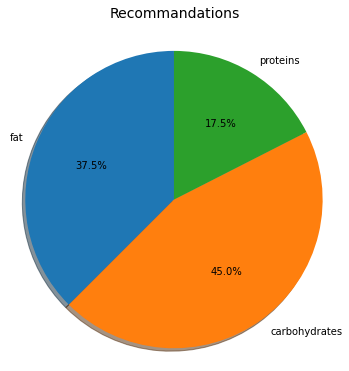

In [212]:
# Valeurs idéales
p_fat = 37.5 # fourchette de 35% à 40%
p_carbs = 45 # fourchette de 40% à 55%
p_prot = 17.5 # fourchette de 15% à 20%

anc = [p_fat, p_carbs, p_prot]
labels = ["fat", "carbohydrates","proteins"]

fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(anc, labels=labels, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Recommandations", pad=20, fontsize=14)
plt.show()

Le contenu moyen est très proche des valeurs recommandées, mais on peut déjà envisager l'utilité de ccombiner des plats de différentes natures pour parvenir à un meilleur équilibre.

### II.1.4 Association d'un macronutriment dominant avec un groupe de produits

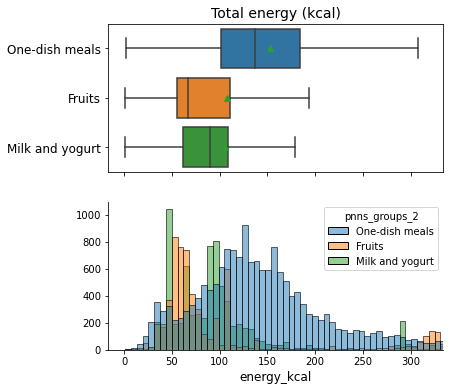

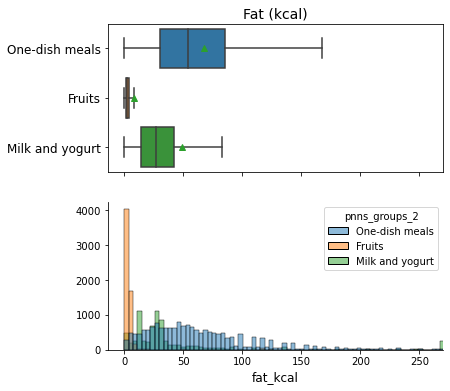

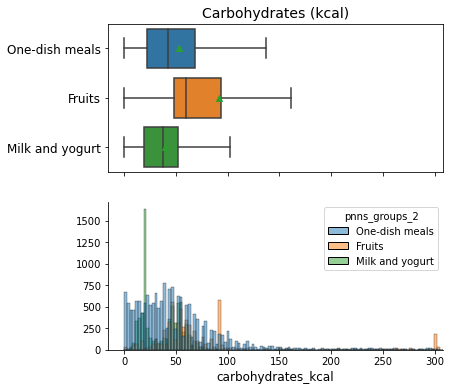

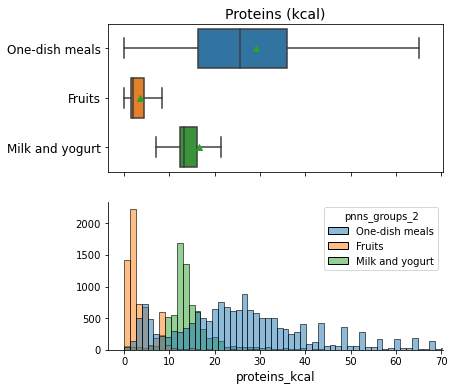

In [213]:
nutricols = ["energy_kcal", "fat_kcal", "carbohydrates_kcal", "proteins_kcal"]
titles = {"energy_kcal": "Total energy (kcal)",
          "fat_kcal": "Fat (kcal)",
          "carbohydrates_kcal": "Carbohydrates (kcal)",
          "proteins_kcal": "Proteins (kcal)"
         }

for c in nutricols:
    q = df1.groupby("pnns_groups_2")[c].quantile(0.95).max()
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
    sns.boxplot(x=c,
                y="pnns_groups_2",
                data=df1,
                showfliers=False,
                showmeans=True,
                #palette="viridis",
                ax=ax1)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.tick_params(axis='y', labelsize=12)
    #ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
    ax1.set_xlim([-q/20, q])
    ax1.set_title(titles[c], fontsize=14)
    
    sns.histplot(x=c,
                 data=df1,
                 hue="pnns_groups_2",
                 ax=ax2
            )
    ax2.set_xlim([-q/20, q])
    ax2.set_xlabel(ax2.get_xlabel(), fontsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    #ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
    ax2.set_ylabel("")
    #ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=10)
    sns.despine(ax=ax2)
    plt.tight_layout
    plt.show()

Chaque groupe d'aliment est associé à une présence plus forte, en moyenne, d'un ou plusieurs macronutriments. On peut ainsi effectuer les rapprochements suivants, sur la base des quelques analyses réalisées ci-dessus:
- les One-dish meals sont en général les produits les plus énergétiques, et constituent la source majeure de lipides et de protéines,
- Les Fruits sont en général la source majeure de fibres et de glucides,
- Les Milk and yogurt consituent une source intermédiare de lipides et de protéines, mais sont pauvres en glucides et en fibres.

Les recommandations de l'application pourront reposer sur ces constatations pour proposer, en association avec un one-dish meal d'un score donné, le meilleur "type" de produit en fonction des apports à réduire ou à augmenter dans la balance globale.

## II.2 Scores

### II.2.1 Score reflétant l'équilibre entre les macronutriments: EquiScore

Pour pouvoir réaliser notre idée d'application, il est nécessaire d'avoir un indicateur qui renseigne sur l'écart d'un produit aux valeurs idéales, en terme de fraction du contenu global. On définit ainsi l'equiscore, calculé comme l'écart, en valeur absolue, entre la composition d'un produit donné et la composition idéale.

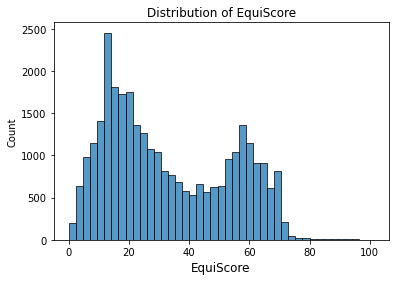

Equiscore:
Minimum: 0.07
Maximum: 101.18
Mean: 32.93
Median: 27.31
Standard deviation: 20.30


In [218]:
X = df1.copy()
# On ne garde que les lignes pour lesquelles aucune des variables ne vaut 0
zeros = X[["fat_kcal", "carbohydrates_kcal", "proteins_kcal"]].sum(axis=1)==0
drop_index = zeros[zeros].index

X.drop(index=drop_index, inplace=True)

# On crée les nouvelles colonnes "fat_ratio", "carbohydrates_ratio" et "proteins_ratio" qui renseigneront sur 
# les ratio de macronutriments dans les contenus globaux.
X.loc[:, "fat_ratio"] = X.apply(lambda x: 100*x["fat_kcal"]/(x["fat_kcal"]+x["carbohydrates_kcal"]+x["proteins_kcal"]), axis=1)
X.loc[:, "carbohydrates_ratio"] = X.apply(lambda x: 100*x["carbohydrates_kcal"]/(x["fat_kcal"]+x["carbohydrates_kcal"]+x["proteins_kcal"]), axis=1)
X.loc[:, "proteins_ratio"] = X.apply(lambda x: 100*x["proteins_kcal"]/(x["fat_kcal"]+x["carbohydrates_kcal"]+x["proteins_kcal"]), axis=1)

sc = cln.score(X["fat_ratio"], X["carbohydrates_ratio"], X["proteins_ratio"], method="sq")

# Nouvelle colonne "score" dans le dataframe
X.loc[:, "score"] = sc
X.head()

# Affichage de la distribution de l'equiscore
sns.histplot(x="score",
            data=X
           )
plt.title("Distribution of EquiScore")
plt.xlabel("EquiScore", fontsize=12)
plt.show()

print("Equiscore:")
print("Minimum: {:.2f}".format(X["score"].min()))
print("Maximum: {:.2f}".format(X["score"].max()))
print("Mean: {:.2f}".format(X["score"].mean()))
print("Median: {:.2f}".format(X["score"].median()))
print("Standard deviation: {:.2f}".format(X["score"].std()))

In [219]:
# On affecte un valeur "fat", "carbohydrates" ou "proteins" dans une nouvelle colonne "excess" qui représente
# le macronutriment en excès dans le produit considéré.
X.loc[:, "fat_excess"] = X["fat_ratio"] - p_fat
X.loc[:, "carbohydrates_excess"] = X["carbohydrates_ratio"] - p_carbs
X.loc[:, "proteins_excess"] = X["proteins_ratio"] - p_prot

# On crée trois nouvelles colonnes: "fat_excess", "carbohydrates_excess", "proteins_excess"
nutrient_cols = ["fat_excess", "carbohydrates_excess", "proteins_excess"]


# On peuple les colonnes "max_excess" et "min_excess" par le nom du macronutriment associé à l'excès le plus 
# élevé en valeur algébrique, c'est-à-dire qu'un excès négatif représente une carence.
X.loc[:, "max_excess"] = X[nutrient_cols].apply(lambda x: x.idxmax(), axis=1)
X.loc[:, "min_excess"] = X[nutrient_cols].apply(lambda x: x.idxmin(), axis=1)
X.loc[:, "max_excess_value"] = X[nutrient_cols].apply(lambda x: x.max(), axis=1)
X.loc[:, "min_excess_value"] = X[nutrient_cols].apply(lambda x: x.min(), axis=1)
X.head()

,product_name,categories_tags,pnns_groups_2,energy_kcal,fat_100g,nutrition-score-fr_100g,nutriscore_grade,fiber_100g,proteins_100g,carbohydrates_100g,...,carbohydrates_ratio,proteins_ratio,score,fat_excess,carbohydrates_excess,proteins_excess,max_excess,min_excess,max_excess_value,min_excess_value
0,Salade de carottes râpées,"en:meals,en:prepared-vegetables,en:grated-carr...",One-dish meals,32.000000,0.3,1.0,b,2.585000,0.9,5.3,...,77.090909,13.090909,42.609266,-27.681818,32.090909,-4.409091,carbohydrates_excess,fat_excess,32.090909,-27.681818
1,Compote de poire,"en:plant-based-foods-and-beverages,en:plant-ba...",Fruits,157.000000,0.0,-2.0,a,3.600000,0.6,36.0,...,98.360656,1.639344,67.120563,-37.500000,53.360656,-15.860656,carbohydrates_excess,fat_excess,53.360656,-37.500000
2,Salade de macedoine de légumes,"en:meals,en:prepared-vegetables,en:starters,en...",One-dish meals,143.000000,12.7,1.0,b,2.885714,1.9,3.9,...,11.345455,5.527273,57.946722,45.627273,-33.654545,-11.972727,fat_excess,carbohydrates_excess,45.627273,-33.654545
3,CORNED BEEF,"en:canned-foods,en:meats,en:meals,en:meat-base...",One-dish meals,235.000000,15.0,17.0,e,0.200000,24.0,1.0,...,1.702128,40.851064,53.083454,19.946809,-43.297872,23.351064,proteins_excess,carbohydrates_excess,23.351064,-43.297872
6,Raviolini au Fromage de chèvre et Pesto,"en:meals,en:microwave-meals",One-dish meals,127.090364,4.2,2.0,b,1.800000,4.4,12.5,...,47.438330,16.698292,3.044129,-1.636622,2.438330,-0.801708,carbohydrates_excess,fat_excess,2.438330,-1.636622


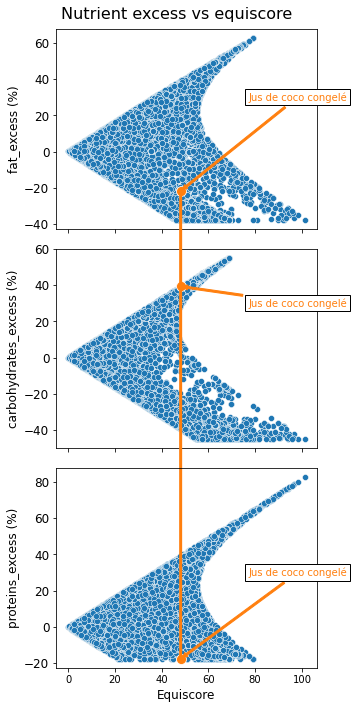

In [284]:
from matplotlib.patches import ConnectionPatch

# placement du titre
pad = 12

# taille de la police
fs = 12

# choix d'un nombre aléatoire compris entre 0 et len(X)
r = np.random.choice(X.shape[0], 1)
product = X.iloc[r]

fig, axs = plt.subplots(nrows=len(nutrient_cols), figsize=(5, 10), sharex=True)
fig.suptitle("Nutrient excess vs equiscore", fontsize=16)
for i, nc in enumerate(nutrient_cols):
    ax=axs[i]
    sns.scatterplot(y=nc, 
                    x="score", 
                    data=X,
                    ax=ax)
    sns.scatterplot(y=nc, x="score", data=product, color="C1", s=100, ax=ax)
    ax.annotate(product.product_name.iloc[0],
                (product["score"], product[nc]), 
                (product["score"]+50, 30),
                ha="center",
                va="center",
                color="C1",
               arrowprops = {"arrowstyle":"simple", "color":"C1"},
               bbox=dict(boxstyle="square,pad=0.3", fc="white", lw=1))
    ax.set_xlabel("Equiscore", fontsize=fs)
    ax.set_ylabel("{} (%)".format(nc), fontsize=fs)
    ax.tick_params(axis='y', labelsize=fs)
    #ax.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
    #ax.set_xlim([-q/20, q])
    #ax.set_title("{}".format(nc), fontsize=14, loc="right")

xyA = (product["score"],product[nutrient_cols[-1]])
xyB = (product["score"],product[nutrient_cols[0]])
coordsA = "data"
coordsB = "data"
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                      axesA=axs[-1], axesB=axs[0], color="C1",
                     )
con.set_linewidth(3)
axs[-1].add_artist(con)
plt.tight_layout()
plt.show()

In [31]:
y = X[["score", "fat_excess", "carbohydrates_excess", "proteins_excess"]]
y = pd.melt(frame=X, 
            id_vars="score", 
            value_vars=["fat_excess", "carbohydrates_excess", "proteins_excess"],
            var_name ="excess_type",
            value_name="excess_value")
y.head()

,score,excess_type,excess_value
0,42.609266,fat_excess,-27.681818
1,67.120563,fat_excess,-37.500000
2,57.946722,fat_excess,45.627273
3,53.083454,fat_excess,19.946809
4,3.044129,fat_excess,-1.636622


<AxesSubplot:xlabel='score', ylabel='excess_value'>

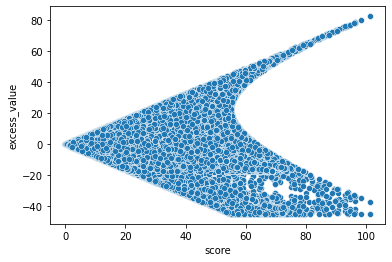

In [38]:
sns.scatterplot(x="score", y="excess_value", data=y)

On attribue des catégories à l'equiscore. Ces catégories sont basées sur les 25ème, 50ème et 75ème percentiles, de manière à avoir 4 classes équilibrées.

In [287]:
# discrétisation du score
tranches = [0, 
            np.round(X["score"].quantile(0.25)), 
            np.round(X["score"].quantile(0.5)), 
            np.round(X["score"].quantile(0.75))]
groups = np.digitize(X["score"], tranches)
X.loc[:, "score_group"] = groups
X.loc[:, "score_group"] = X["score_group"].map({1:"a", 2:"b", 3:"c", 4:"d"})

X.head()

,product_name,categories_tags,pnns_groups_2,energy_kcal,fat_100g,nutrition-score-fr_100g,nutriscore_grade,fiber_100g,proteins_100g,carbohydrates_100g,...,proteins_ratio,score,fat_excess,carbohydrates_excess,proteins_excess,max_excess,min_excess,max_excess_value,min_excess_value,score_group
0,Salade de carottes râpées,"en:meals,en:prepared-vegetables,en:grated-carr...",One-dish meals,32.000000,0.3,1.0,b,2.585000,0.9,5.3,...,13.090909,42.609266,-27.681818,32.090909,-4.409091,carbohydrates_excess,fat_excess,32.090909,-27.681818,c
1,Compote de poire,"en:plant-based-foods-and-beverages,en:plant-ba...",Fruits,157.000000,0.0,-2.0,a,3.600000,0.6,36.0,...,1.639344,67.120563,-37.500000,53.360656,-15.860656,carbohydrates_excess,fat_excess,53.360656,-37.500000,d
2,Salade de macedoine de légumes,"en:meals,en:prepared-vegetables,en:starters,en...",One-dish meals,143.000000,12.7,1.0,b,2.885714,1.9,3.9,...,5.527273,57.946722,45.627273,-33.654545,-11.972727,fat_excess,carbohydrates_excess,45.627273,-33.654545,d
3,CORNED BEEF,"en:canned-foods,en:meats,en:meals,en:meat-base...",One-dish meals,235.000000,15.0,17.0,e,0.200000,24.0,1.0,...,40.851064,53.083454,19.946809,-43.297872,23.351064,proteins_excess,carbohydrates_excess,23.351064,-43.297872,d
6,Raviolini au Fromage de chèvre et Pesto,"en:meals,en:microwave-meals",One-dish meals,127.090364,4.2,2.0,b,1.800000,4.4,12.5,...,16.698292,3.044129,-1.636622,2.438330,-0.801708,carbohydrates_excess,fat_excess,2.438330,-1.636622,a


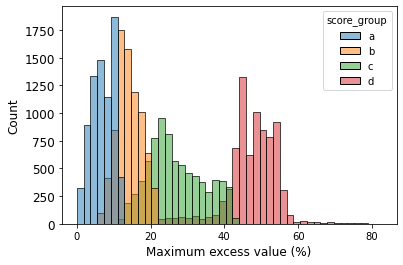

In [292]:
fs = 12

fig, ax = plt.subplots()
sns.histplot(x="max_excess_value", 
             data=X.sort_values(by="score_group"),  
             hue="score_group",
            ax=ax)
ax.set_xlabel("Maximum excess value (%)", fontsize=fs)
ax.set_ylabel("Count", fontsize=fs)
ax.tick_params(axis='y', labelsize=fs)
plt.show()

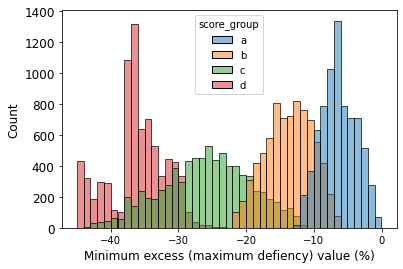

In [293]:
fs = 12

fig, ax = plt.subplots()

sns.histplot(x="min_excess_value", 
             data=X.sort_values(by="score_group"), 
             bins=int(np.abs(X.min_excess_value).max()), 
             hue="score_group",
            ax=ax)
ax.set_xlabel("Minimum excess (maximum defiency) value (%)", fontsize=fs)
ax.set_ylabel("Count", fontsize=fs)
ax.tick_params(axis='y', labelsize=fs)
plt.show()

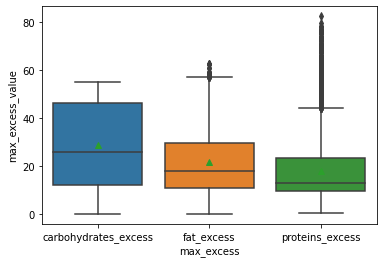

In [99]:
sns.boxplot(x="max_excess", 
            y="max_excess_value", 
            data=X.sort_values(by="max_excess"), 
            showmeans=True)
plt.show()

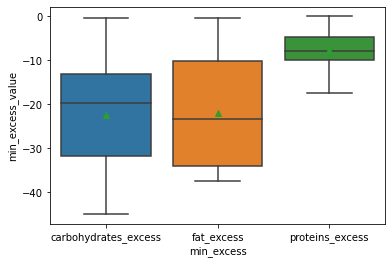

In [313]:
sns.boxplot(x="min_excess", 
            y="min_excess_value", 
            data=X.sort_values(by="min_excess"), 
            showmeans=True)
plt.show()

**Quelle est la relation entre l'equiscore et le type de macronutriments dont l'excès (la carence) est maximal(e) ? L'equiscore et le type de nutriment en excès sont-ils corrélés?**

Tableau de contingence:


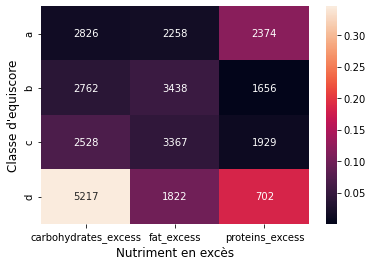

In [126]:
# Création du tableau de contingence
x = "score_group"
y = "max_excess"

cont = X[[x,y]].pivot_table(index=x,columns=y,aggfunc=len,margins=True,margins_name="Total")
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = cont.loc["Total", "Total"]
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")
plt.ylabel("Classe d'equiscore", fontsize=12)
plt.xlabel("Nutriment en excès", fontsize=12)
print("Tableau de contingence:")
plt.show()

Etant donné la valeur très élevée de la distance du khi-deux (> 3040), on en déduit l'existence d'une corrélation entre le type de nutriment le plus en excès et le groupe d'equiscore.

En particulier:

- Dans la classe d'equiscore d les excès en glucides sont les excès principaux dans 67% des cas
- 40% des produits dont l'excès principal provient des glucides sont des produits du groupe d
- Dans cette même classe d'equiscore (d), les produits dont l'excès principal est un excès en protéines sont particulièrement sous-représentés: ils ne représentent que 9% des produits, tandis qu'ils représentent 22% des produits toutes catégories confondues.
- Enfin, les produits dont l'excès en protéines est le principal excès sont surreprésentés dans le groupe d'equiscore a: ils représentent en effet 32% de l'ensemble des produits de catégorie a.

La catégorie a, associée aux produits les plus équilibrés par construction, est composée pour 1/3 de produits principalement "surchargés" en lipides, 1/3 en protéines, et 1/3 en glucides.

Tableau de contingence:


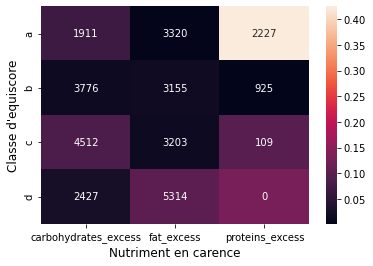

In [107]:
# Création du tableau de contingence
x = "score_group"
y = "min_excess"

cont = X[[x,y]].pivot_table(index=x,columns=y,aggfunc=len,margins=True,margins_name="Total")
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = cont.loc["Total", "Total"]
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")
plt.ylabel("Classe d'equiscore", fontsize=12)
plt.xlabel("Nutriment en carence", fontsize=12)
print("Tableau de contingence:")
plt.show()

Les produits de forte carence en protéines sont surreprésentés dans la classe d'equiscore a, les produits de fortes carences en glucides et lipides le sont dans les classe c et d, respectivement, où les produits carencés en protéines sont singulièrement sous-représentés.

### II.2.2 Distribution des valeurs du nutriscore

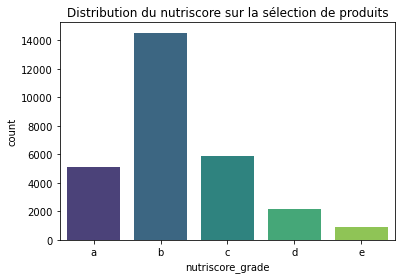

In [17]:
sns.countplot(x="nutriscore_grade",
            data=X.sort_values(by="nutriscore_grade"),
             palette="viridis")
plt.title("Distribution du nutriscore sur la sélection de produits")
plt.show()

### II.2.3 Analyse croisée des scores

Il s'agit ici de regarder comment ces deux scores sont corrélés entre eux ou non. L'idée de l'application repose sur l'hypothèse que le nutriscore seul ne suffit pas pour sélectionner des produits dont la répartition des divers macronutriments se rapproche des ANC.

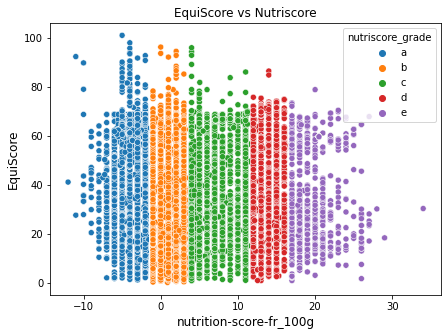

In [149]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x="nutrition-score-fr_100g",
                y="score",
                data=X.sort_values(by="nutriscore_grade"),
                hue="nutriscore_grade"
               )
plt.title("EquiScore vs Nutriscore")
plt.xlabel("nutrition-score-fr_100g", fontsize=12)
plt.ylabel("EquiScore", fontsize=12)
plt.show()

**Test d'indépendance equiscore vs. nutriscore par ANOVA**

In [156]:
mod = ols('score ~ nutriscore_grade', data=X.dropna(subset=["score", "nutriscore_grade"], how="any")).fit()           
aov_table = sm.stats.anova_lm(mod, typ=2)
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print("Résultats de l'analyse ANOVA pour les variable score et nutriscore_grade:")
print("F: {:.2f}, p: {:.3f}".format(aov_table.iloc[0]["F"], aov_table.iloc[0]["PR(>F)"]))
print("Eta-squared: {:.4f}".format(esq_sm))

Résultats de l'analyse ANOVA pour les variable score et nutriscore_grade:
F: 2149.73, p: 0.000
Eta-squared: 0.2205


Table de contingence:


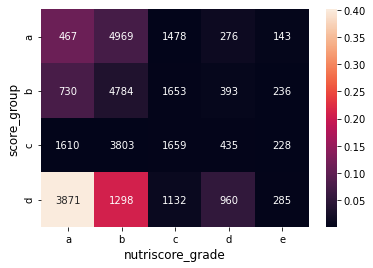

Table d'indépendance, à titre de comparaison:


nutriscore_grade,a,b,c,d,e,Total
score_group,,,,,,
a,1610,3581,1428,497,215,7333
b,1711,3808,1518,529,228,7796
c,1698,3778,1506,524,226,7735
d,1657,3685,1469,512,221,7546
Total,6678,14854,5922,2064,892,30410


In [179]:
# Création du tableau de contingence
x = "score_group"
y = "nutriscore_grade"

cont = X[[x,y]].pivot_table(index=x,columns=y,aggfunc=len,margins=True,margins_name="Total")
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = cont.loc["Total", "Total"]
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
plt.ylabel("Groupe d'equiscore", fontsize=12)
plt.xlabel("Classe de nutriscore", fontsize=12)
print("Table de contingence:")
sns.heatmap(table.iloc[:-1,:-1], annot=c.iloc[:-1,:-1], fmt=".0f")
plt.show()
print("Table d'indépendance, à titre de comparaison:")
indep.astype('int')

Ce résultat est intéressant: il nous dit, contrairement à nos attentes, qu'il existe bien une prévalence des groupes de nutriscore "a", et "d" dans le groupe d'équiscore "d". Cependant, il n'y a pas de corrélation "simple" entre les deux scores: un groupe de plus faible equiscore n'est pas en général associé à un groupe de meilleur nutriscore.

### II.2.4 Exemples

Exemple de produits de nutriscore a et d'equiscore d

In [166]:
X.loc[(X.score_group=="d") & (X.nutriscore_grade=="a"), ["product_name","fat_excess", "carbohydrates_excess", "proteins_excess", "fiber_kcal"]].sample(10)

,product_name,fat_excess,carbohydrates_excess,proteins_excess,fiber_kcal
10241,Poires demi-fruits au sirop léger,-30.733083,45.225564,-14.492481,3.089565
4060,Hi-protein greek style strained yogurt,-34.364111,-15.731707,50.095819,0.404041
35237,Purée pomme abricot,-35.581023,48.816631,-13.235608,4.560000
29414,Couscous royal,-15.152370,-34.164786,49.317156,4.173796
20878,Ananas En Morceaux Au Sirop Léger Top Budget,-31.767516,46.719745,-14.952229,1.722667
17168,Purée de pommes bananes,-29.807692,43.888889,-14.081197,2.660000
13264,Spécialité de fruits pomme mangue passion,-32.738095,46.710758,-13.972663,3.800000
29758,Clementine Bio,-32.155094,42.711284,-10.556190,3.002000
26959,Compote pomme poire,-34.449153,49.915254,-15.466102,4.180000
22533,Pomme Poire Williams,-37.500000,55.000000,-17.500000,3.230000


Exemples de produits de nutriscore d ou e, et d'equiscore a

In [167]:
X.loc[(X.score_group=="a") & ((X.nutriscore_grade=="d") | (X.nutriscore_grade=="e")), ["product_name","fat_excess", "carbohydrates_excess", "proteins_excess", "fiber_kcal"]].sample(10)

,product_name,fat_excess,carbohydrates_excess,proteins_excess,fiber_kcal
33541,poulet au curry et son riz,-9.375000,5.000000,4.375000,1.773333
9097,Demi-Lune au saumon et ciboulette,12.193252,-6.963190,-5.230061,1.900000
7667,CREPE CHOCOLAT,6.787548,4.636286,-11.423834,3.230000
16956,8 GYOSA aux crevettes,-7.729008,8.435115,-0.706107,2.090000
14057,Ravioles du Dauphiné,1.181948,-2.163324,0.981375,1.411429
13010,12 feuilletés aux noix de St-Jacques,9.531785,-1.354011,-8.177775,5.687333
11167,Crepes de froment jambon emmental,7.054455,-11.336634,4.282178,1.535833
30015,Boeuf bourguignon et pâtes,-9.375000,8.125000,1.250000,2.982174
2734,milk shake,-4.925026,9.601861,-4.676836,0.000000
15132,Frusta ai Formaggi,-9.664948,8.264605,1.400344,2.470000


Produit d'equiscore maximum

In [295]:
X.loc[X.score.idxmax(), ["product_name",
                          "pnns_groups_2", 
                          "energy_kcal",
                          "score",
                          "fat_excess", 
                          "carbohydrates_excess", 
                          "proteins_excess"]]

product_name            Filets de Merlu Blanc
pnns_groups_2                  One-dish meals
energy_kcal                                73
score                                 101.181
fat_excess                              -37.5
carbohydrates_excess                      -45
proteins_excess                          82.5
Name: 14460, dtype: object

Produit d'equiscore minimum

In [296]:
X.loc[X.score.idxmin(), ["product_name",
                          "pnns_groups_2", 
                          "energy_kcal",
                          "score",
                          "fat_excess", 
                          "carbohydrates_excess", 
                          "proteins_excess"]]

product_name            Tomates farcies
pnns_groups_2            One-dish meals
energy_kcal                       108.5
score                         0.0739735
fat_excess                    0.0487531
carbohydrates_excess         0.00650041
proteins_excess              -0.0552535
Name: 7753, dtype: object

Le produit d'equiscore maximal est un filet de poisson: presque uniquement des protéines, très peu de graisses ou de glucides. Le produit d'equiscore minimal est un plat de tomates farcies: une combinaison de legumes et de viande ramenant les excès à des valeurs proches de 0.

Ces quelques explorations illustrent la complémentarité des deux scores.

### II.2.4 Nutriments en excès/carence dans les groupes d'aliments

Au vu des résultats obtenus jusqu'ici, on peut se demander comment l'equiscore est associé à la présence de telle ou telle catégorie de nutriment. En théorie, un produit peut contenir n'importe quelle combinaison de macronutriments, et ainsi un equiscore élevé peut correspondre à des produits présentant des carences en n'importe qu'elle catégorie de macronutriment, et des surplus dans les autres. Mais qu'en est-il en pratique sur notre jeu de données? Peut-on associer un groupe d'aliment à un excès/carence dans un (plusieurs) macronutriment(s) particulier(s)?

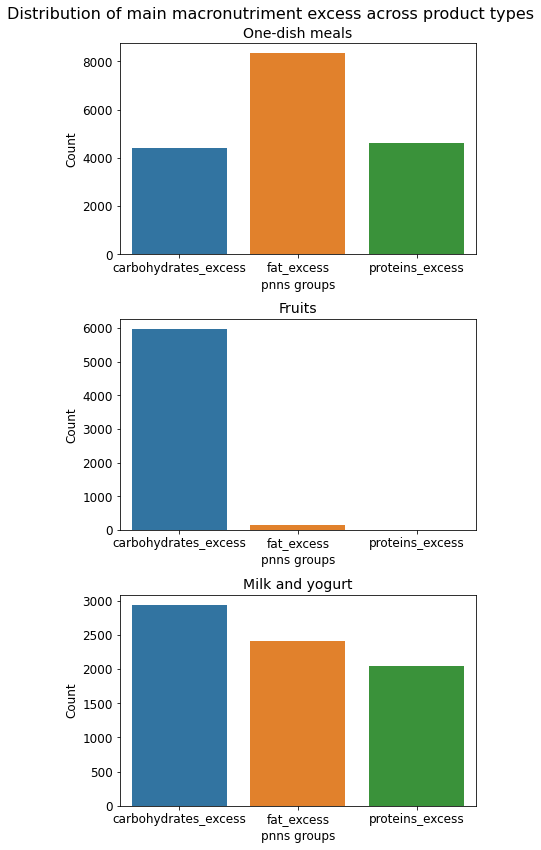

In [312]:
fs = 12
fig, axs = plt.subplots(nrows=X.pnns_groups_2.unique().size, figsize=(6, 12))
fig.suptitle("Distribution of main macronutriment excess across product types", fontsize=16)
for i, g in enumerate(X.pnns_groups_2.unique()):
    ax = axs[i]
    sns.countplot(x="max_excess", data=X[X.pnns_groups_2==g].sort_values(by="max_excess"), ax=ax)
    ax.set_xlabel("pnns groups", fontsize=fs)
    ax.set_ylabel("Count", fontsize=fs)
    ax.tick_params(axis='y', labelsize=fs)
    ax.tick_params(axis="x", labelsize=fs)
    ax.set_title(g, fontsize=14)
plt.tight_layout()
plt.show()

# Conclusion

Le principe de fonctionnement repose essentiellement sur l'equiscore, qui permet de calculer l'écart d'une composition d'un produit à la composition idéale. Pour que l'application puisse fonctionner, il faut pouvoir "équilibrer" les apports d'un plat, avec les apports d'un autre plat. Or nous avons vu que les One-dish meals, les Fruits et les Milk and yogurt sont chacuns "spécialisés" dans un ou plusieurs macro-nutriment:
- les lipides et protéines en ce qui concerne les One-dish meals
- les glucides et les fibres en ce qui concerne les fruits
- les lipides et les protéines également en ce qui concerne le Milk and yogurt

Pour aller plus loin, on pourrait par exemple selectionner aléatoirement un one-dish meal, et à partir de sa composition décider si il faut lui adjoindre un fruit (carence en glucides) ou un yaourt (carence en lipides et/ou protéines) pour retrouver une meilleure composition. Il s'agira ensuite de calculer le nouvel equiscore et vérifier qu'il est bien inférieur au score initial. Enfin répéter cette opération un grand nombre de fois et vérifier à l'aide d'un test statistique approprié qu'on obtient de meilleurs résultats avec l'app que sans l'app.

# -----------------------------------------------------------------

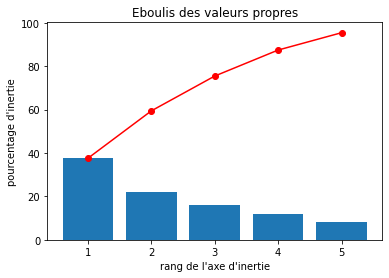

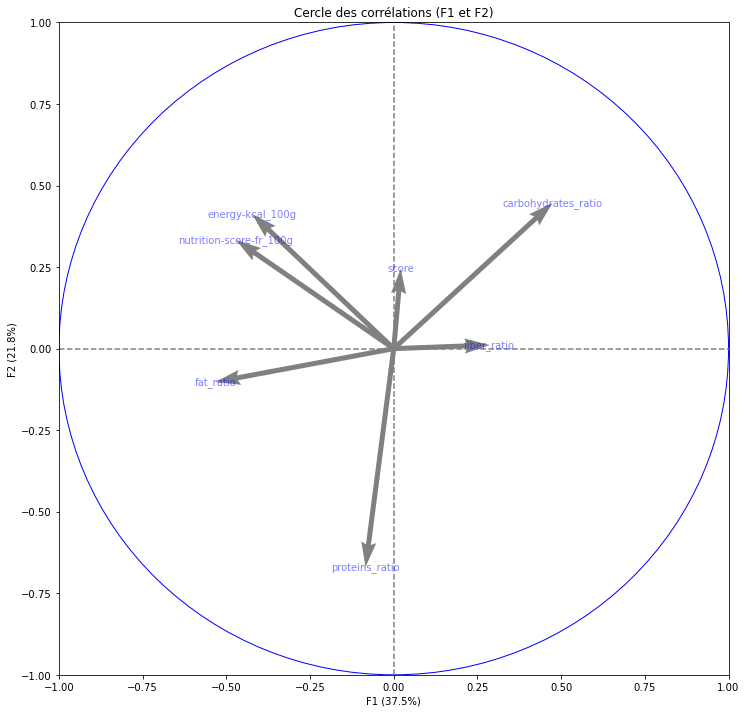

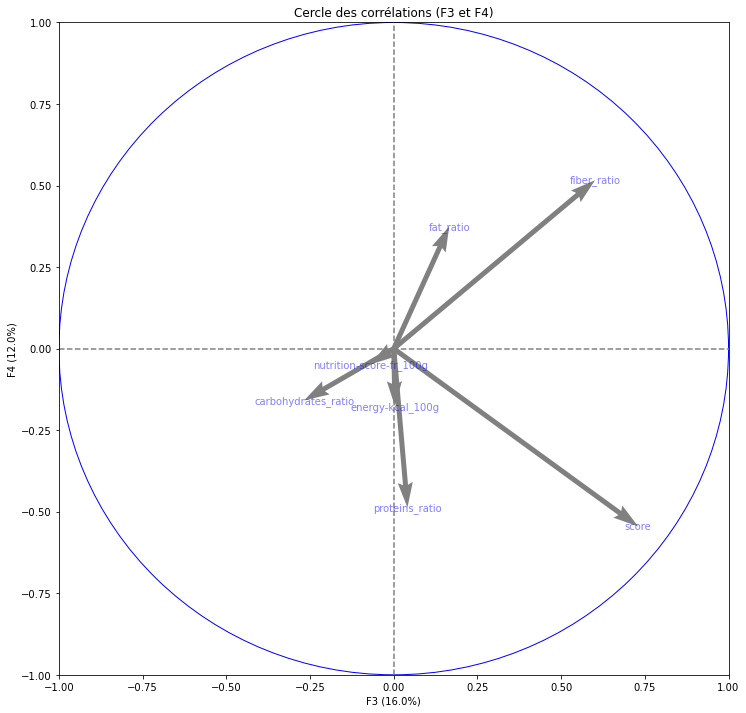

In [26]:
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

# On ne récupère que les lignes pour lesquelles nutrition-score-fr_100g est renseignée.
y = X.loc[X["nutrition-score-fr_100g"].notna()]
y.index = pd.Index(range(0, y.shape[0]))

# On ne garde que les colonnes à prendre en compte dans l'ACP (c'est-à-dire les colonnes de valeurs numériques)
df_acp = y[["energy-kcal_100g", "nutrition-score-fr_100g",
            "fat_ratio","carbohydrates_ratio","proteins_ratio", "score", "fiber_ratio"]].dropna(subset=["score"])

features = df_acp.columns
index = y.index

# choix du nombre de composantes à calculer
n_comp = 5

# Centrage et RéductionS
std_scale = preprocessing.StandardScaler().fit(df_acp)
X_scaled = std_scale.transform(df_acp)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1), (2, 3)], labels = np.array(features))

In [27]:
print_acp_analysis(df_acp, pca)


F1 donné par :

carbohydrates_ratio 0.47
fiber_ratio 0.29
score 0.02
proteins_ratio -0.08
energy-kcal_100g -0.42
nutrition-score-fr_100g -0.47
fat_ratio -0.53

F2 donné par:

carbohydrates_ratio 0.45
energy-kcal_100g 0.41
nutrition-score-fr_100g 0.33
score 0.25
fiber_ratio 0.01
fat_ratio -0.10
proteins_ratio -0.67

F3 donné par:

score 0.73
fiber_ratio 0.60
fat_ratio 0.17
proteins_ratio 0.04
energy-kcal_100g 0.00
nutrition-score-fr_100g -0.07
carbohydrates_ratio -0.27


Le premier axe d'inertie est principalement corrélé à "fat_ratio", "fiber_ratio", et principalement anticorrélé à carbohydrates_ratio. Il est corrélé dans une moindre mesure avec "score" (c'est-à-dire l'equiscore), "nutrition-score-fr_100g" puis "energy-kcal_100g".

Le deuxième axe est principalement corrélé à "proteins_ratio". Il est ensuite anticorrélé à "energy-kcal_100g", "carbohydrates_ratio" et "nutrition-score-fr_100g".

Le troisième axe est principalement corrélé à proteins_ratio, energy-kcal_100g, nutrition-score-fr_100g, et principalement anticorrélé à score

Le dernier axe est lui essentiellement corrélé à "score", corrélé également à proteins_ratio, et anticorrélé à fat_ratio et fiber_ratio.

On a donc 4 groupes de variables, correspondant à chacun des quatre axes. Par rapport à notre problématique initiale, on peut donc considérer qu'on a trois variables synthétiques: 
- la première va nous permettre de sélectionner les produits directement selon leur contenu en fibres, lipides et glucides.
- la deuxième va nous permettre de sélectionner les produits selon leur contenu en protéines. Affichons quelques exemples concrets.

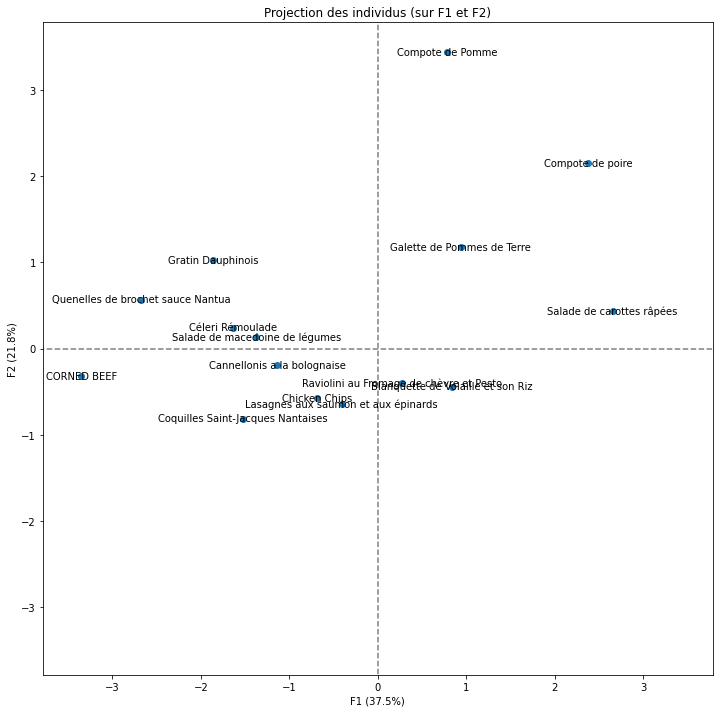

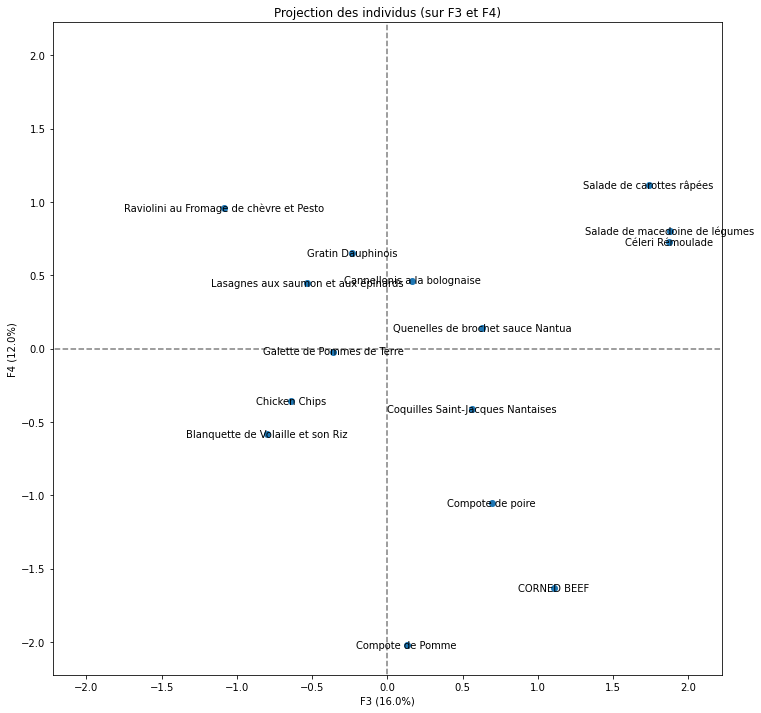

In [28]:
# Projections des individus
id = index[:15]
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected[id], n_comp, pca, [(0,1),(2,3)], labels=y.iloc[id]["product_name"].to_numpy())
#X_projected[:, "score_group"] = score

In [29]:
print_product_analysis(y, X_projected, 0, 7, axe=1)

Pour deux produits de F1 différents:

Premier produit: Salade de carottes râpées (Valeur élevée):
energy-kcal_100g                  32
fat_ratio                  0.0835913
carbohydrates_ratio         0.656347
proteins_ratio              0.111455
fiber_ratio                 0.148607
score                       0.659907
nutrition-score-fr_100g            1
Name: 0, dtype: object
----------------------------------------
Deuxième produit: Céleri Rémoulade (Valeur basse):
energy-kcal_100g                 145
fat_ratio                   0.810249
carbohydrates_ratio        0.0969529
proteins_ratio             0.0554017
fiber_ratio                0.0373961
score                       0.945291
nutrition-score-fr_100g            3
Name: 7, dtype: object


**On retrouve donc le fait que le produit de F1 plus élevé (à F2 identique) est plus énergétique et gras, contient plus de fibres et contient moins de glucides (pour 100g)**

In [30]:
print_product_analysis(y, X_projected, 4, 6, axe=2)

Pour deux produits de F2 différents:

Premier produit: Blanquette de Volaille et son Riz (Valeur basse):
energy-kcal_100g                  109
fat_ratio                    0.181402
carbohydrates_ratio          0.560696
proteins_ratio               0.249198
fiber_ratio                0.00870362
score                        0.369789
nutrition-score-fr_100g             0
Name: 4, dtype: object
----------------------------------------
Deuxième produit: Compote de Pomme (Valeur élevée):
energy-kcal_100g                  377
fat_ratio                   0.0116701
carbohydrates_ratio           0.96473
proteins_ratio              0.0155602
fiber_ratio                0.00803942
score                         1.02946
nutrition-score-fr_100g             1
Name: 6, dtype: object


**On retrouve donc le fait que le produit de F2 plus élevé (à F1 identique) est moins énergétique, contient moins de glucides et plus de protéines**

In [31]:
print_product_analysis(y, X_projected, 9, 13, axe=3)

Pour deux produits de F3 différents:

Premier produit: Chicken Chips (Valeur basse):
energy-kcal_100g                 198
fat_ratio                   0.324649
carbohydrates_ratio         0.352705
proteins_ratio              0.306613
fiber_ratio                0.0160321
score                       0.263226
nutrition-score-fr_100g            4
Name: 9, dtype: object
----------------------------------------
Deuxième produit: Cannellonis a la bolognaise (Valeur élevée):
energy-kcal_100g                 169
fat_ratio                   0.579286
carbohydrates_ratio         0.241077
proteins_ratio              0.159157
fiber_ratio                0.0204798
score                       0.458572
nutrition-score-fr_100g            3
Name: 13, dtype: object


**On retrouve le fait que le produit de F3 plus élevé (à F4 identique) contient plus de protéines, est plus énergétique, possède un nutriscore plus élevé et un score moins élevé.**

Ces axes peuvent être utiles si par exemple, on souhaite équilibrer un premier produit par un produit possédant un ensemble de caractéristiques:
- en se déplaçant sur F1 à F2 égal, on pourra sélectionner des produits dont le contenu en protéines est à peu près similaire, mais dont les contenus en lipides, glucides et fibres sont différents.
- de même, en se déplaçant sur 

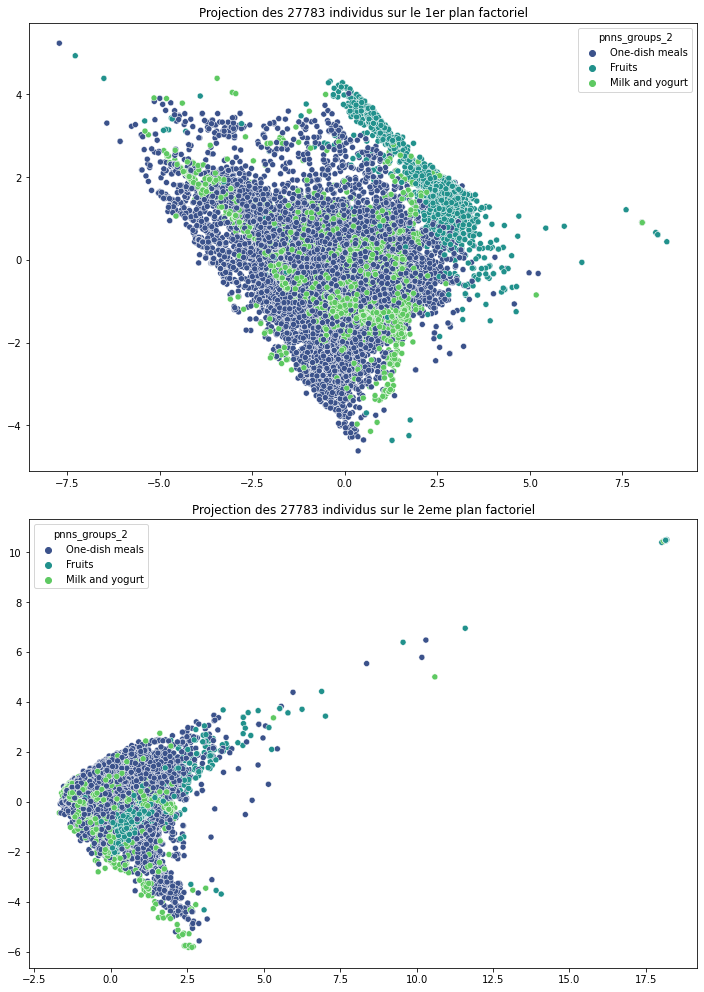

In [32]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 14))
# Affichage du clustering par projection des individus sur le premier plan factoriel
#pca = decomposition.PCA(n_components=4).fit(df_acp)
#X_projected = pca.transform(df_acp)
sns.scatterplot(x=X_projected[:, 0], 
                y=X_projected[:, 1], 
                data=X_projected, 
                hue=y.dropna(subset=["score"])["pnns_groups_2"], 
                palette="viridis",
                ax=ax1)
ax1.set_title("Projection des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

sns.scatterplot(x=X_projected[:, 2], 
                y=X_projected[:, 3], 
                data=X_projected,
                hue=y.dropna(subset=["score"])["pnns_groups_2"], 
                palette="viridis", 
                ax=ax2)
ax2.set_title("Projection des {} individus sur le 2eme plan factoriel".format(X_projected.shape[0]))

plt.tight_layout(pad=1.5)
plt.show()

In [33]:
def print_product_analysis(df, X_proj, id1, id2, axe=1):
    
    prod1 = dict()
    prod2 = dict()
    
    # Récupération du nom des produits à partir des index
    prod1["name"] = df.iloc[id1]["product_name"]
    prod2["name"] = df.iloc[id2]["product_name"]
    
    # analyse selon l'axe choisi
    if axe==1:
        print("Pour deux produits de F1 différents:\n")
    elif axe==2:
        print("Pour deux produits de F2 différents:\n")
    elif axe==3:
        print("Pour deux produits de F3 différents:\n")
    
    # Variables conservées pour l'analyse
    var = ["energy-kcal_100g",
           "fat_ratio", 
           "carbohydrates_ratio",
           "proteins_ratio",
           "fiber_ratio",
           "score",
           "nutrition-score-fr_100g"]
    
    
    # Valeur basse vs. valeur élevée pour l'axe
    prod1["val"] = X_proj[id1, axe-1]
    prod2["val"] = X_proj[id2, axe-1]
    text1 = "Valeur basse"
    text2 = "Valeur élevée"
    
    if prod1["val"] < prod2["val"]:
        prod1["text"] = text1
        prod2["text"] = text2
    else:
        prod1["text"] = text2
        prod2["text"] = text1
    
    # Affichage de l'analyse
    print(f"Premier produit: {prod1['name']} ({prod1['text']}):")
    print(df.iloc[id1][var])
    print("-"*40)
    print(f"Deuxième produit: {prod2['name']} ({prod2['text']}):")
    print(df.iloc[id2][var])

In [34]:
def print_acp_analysis(df, pca):
    print("\nF1 donné par :\n")
    for v,c in sorted(list(zip(df.columns.to_numpy(), pca.components_[0])), key=lambda x: x[1], reverse=True):
        print("{} {:.2f}".format(v,c))
    print("\nF2 donné par:\n")
    for v,c in sorted(list(zip(df.columns.to_numpy(), pca.components_[1])), key=lambda x: x[1], reverse=True):
        print("{} {:.2f}".format(v,c))
    print("\nF3 donné par:\n")
    for v,c in sorted(list(zip(df.columns.to_numpy(), pca.components_[2])), key=lambda x: x[1], reverse=True):
        print("{} {:.2f}".format(v,c))
    print("\nF4 donné par:\n")
    for v,c in sorted(list(zip(df.columns.to_numpy(), pca.components_[3])), key=lambda x: x[1], reverse=True):
        print("{} {:.2f}".format(v,c))

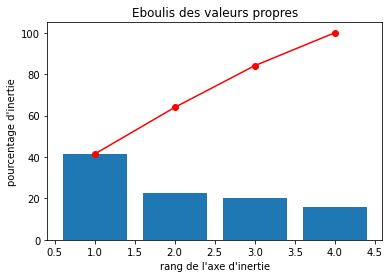

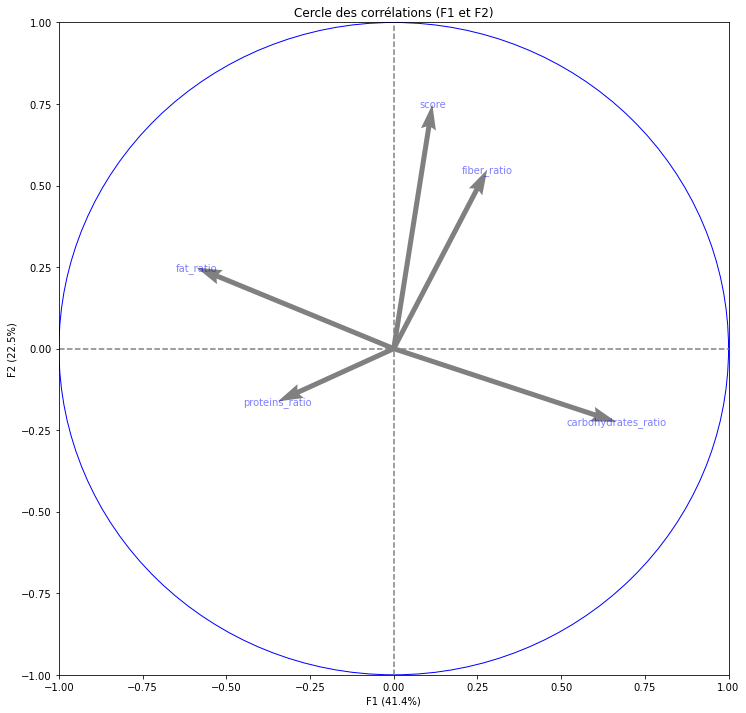

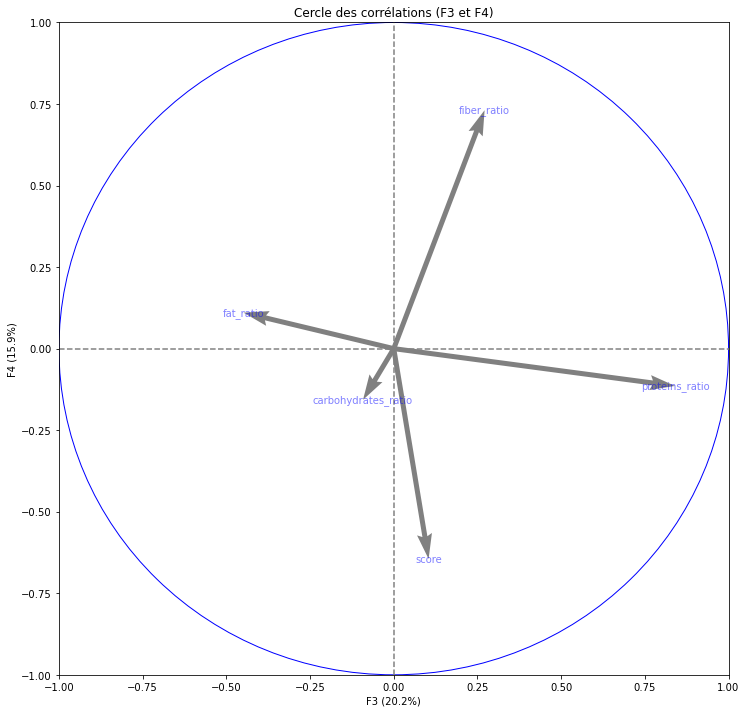

In [35]:
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

# On ne récupère que les lignes pour lesquelles nutrition-score-fr_100g est renseignée.
y = X.loc[X["nutrition-score-fr_100g"].notna()]
y.index = pd.Index(range(0, y.shape[0]))

# On ne garde que les colonnes à prendre en compte dans l'ACP (c'est-à-dire les colonnes de valeurs numériques)
df_acp = y[["fat_ratio","carbohydrates_ratio","proteins_ratio", "score", "fiber_ratio"]].dropna(subset=["score"])

features = df_acp.columns
index = y.index

# choix du nombre de composantes à calculer
n_comp = 4

# Centrage et RéductionS
std_scale = preprocessing.StandardScaler().fit(df_acp)
X_scaled = std_scale.transform(df_acp)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1), (2, 3)], labels = np.array(features))

In [36]:
print_acp_analysis(df_acp, pca)


F1 donné par :

carbohydrates_ratio 0.66
fiber_ratio 0.28
score 0.12
proteins_ratio -0.35
fat_ratio -0.59

F2 donné par:

score 0.75
fiber_ratio 0.55
fat_ratio 0.25
proteins_ratio -0.16
carbohydrates_ratio -0.22

F3 donné par:

proteins_ratio 0.84
fiber_ratio 0.27
score 0.10
carbohydrates_ratio -0.09
fat_ratio -0.45

F4 donné par:

fiber_ratio 0.73
fat_ratio 0.11
proteins_ratio -0.11
carbohydrates_ratio -0.16
score -0.64
